### Кейс № 1

### Постановка задачи

Имеется 80 моторов, каждый из которых живет определенное число циклов. Каждый цикл происходит снятие информации с датчиков S1 – S21 и происходит переустановка настроечных параметров Setting1 – Setting2.
Необходимо: 
Провести анализ предоставленных данных по 80 моторам (файл Data_80.csv). Сделать предположение о выходе из строя мотора на основании имеющихся данных датчиков. Далее на основании дополнительно предоставленных данных по 20 моторам (файл Data_Add_20.csv) сделать предположения о выходе мотора из строя на следующем цикле.
Инструменты:
Любые инструменты Data Science.

#### Предварительные рассуждения:
Известно, что в течение всех циклов моторы работали, следовательно, у нас отсутствуют примеры циклов, когда мотор вышел из строя. Если принять, что большинство циклов измерений характеризуют нормальное поведение моторов, то будем искать аномальные режимы, которые могут потенциально повлиять на выход мотора из строя. Наверное, если такие аномалии присутствую на последних рабочих циклах, то это существенно повышает вероятность их поломки на следующем цикле. В выборке нужно найти циклы, которые не похожи на большинство циклов. Объекты моторы и их некоторые циклы, которые выделяются - являются аномалиями. У нас нет примеров аномалий, и мы не знаем, где в обучающей выборке они находятся. Нужно уметь отвечать на вопрос, похож ли данный рабочий цикл мотора на все остальные или он является аномальным и приведет в будущем к поломке мотора. Возможно поведение некоторых моторов, в целом,статистически, выбивается среди всех остальных и также является аномальным (нужно проверить эту гипотезу!)
Мы рассмотрим следующие подходы к обнаружению аномалий:
1. Метод, основанный на статистическом анализе показаний датчиков. Статистический поиск аномалий в показаниях датчиков. Мы находим распределение, которые хорошо описывает имеющуюся выборку. 
Затем мы смотрим на объектах, насколько вероятно было получить его из этого распределения. Чем больше отличие 
в распределениях признаков, тем больше вероятность, что цикл является аномальным и может привести к будущей поломке. Также мы будем анализировать циклы и искать те, которые статистически отличаются от всех остальных, они будут ассоцироваться с искомыми аномалиями.
2. Методы машинного обучения, основанные на классификации

### 1. Подгружаем библиотеки

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
from scipy.stats import shapiro
from sklearn.preprocessing import MinMaxScaler
from sklearn import manifold
from sklearn.feature_selection import VarianceThreshold
from sklearn import svm
from matplotlib.colors import ListedColormap
from scipy import stats
import operator
from scipy import optimize

from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor

import warnings
warnings.filterwarnings('ignore')

%pylab inline

Populating the interactive namespace from numpy and matplotlib


### 2. Загружаем данные

In [2]:
data1 = pd.read_csv("Data_80.csv", sep = ";", header=0)

In [3]:
data2 = pd.read_csv("Data_Add_20.csv", sep = ";", header=0)

### 3. Первичная аналитика 
Смотрим, какова структура и формат данных

In [4]:
data1.shape

(16138, 25)

In [5]:
data2.shape

(4051, 26)

In [6]:
data2.columns  # все доступные признаки

Index(['f', 'cycle', 's1', 's10', 's11', 's12', 's13', 's14', 's15', 's16',
       's17', 's18', 's19', 's2', 's20', 's21', 's3', 's4', 's5', 's6', 's7',
       's8', 's9', 'setting1', 'setting2', ' Brake'],
      dtype='object')

In [7]:
data2 = data2.drop([' Brake'], axis = 1)

In [8]:
data2.columns = data1.columns

In [9]:
data1.columns

Index(['id', 'cycle', 's1', 's10', 's11', 's12', 's13', 's14', 's15', 's16',
       's17', 's18', 's19', 's2', 's20', 's21', 's3', 's4', 's5', 's6', 's7',
       's8', 's9', 'setting1', 'setting2'],
      dtype='object')

#### 3.1. Проверяем формат данных

In [10]:
data1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16138 entries, 0 to 16137
Data columns (total 25 columns):
id          16138 non-null object
cycle       16138 non-null int64
s1          16138 non-null float64
s10         16138 non-null float64
s11         16138 non-null float64
s12         16138 non-null float64
s13         16138 non-null float64
s14         16138 non-null float64
s15         16138 non-null float64
s16         16138 non-null float64
s17         16138 non-null int64
s18         16138 non-null int64
s19         16138 non-null int64
s2          16138 non-null float64
s20         16138 non-null float64
s21         16138 non-null float64
s3          16138 non-null float64
s4          16138 non-null float64
s5          16138 non-null float64
s6          16138 non-null float64
s7          16138 non-null float64
s8          16138 non-null float64
s9          16138 non-null float64
setting1    16138 non-null float64
setting2    16138 non-null float64
dtypes: float64(20), int6

#### 3.2. Проверяем на наличие пропусков NaN

In [11]:
data1.isnull().any()

id          False
cycle       False
s1          False
s10         False
s11         False
s12         False
s13         False
s14         False
s15         False
s16         False
s17         False
s18         False
s19         False
s2          False
s20         False
s21         False
s3          False
s4          False
s5          False
s6          False
s7          False
s8          False
s9          False
setting1    False
setting2    False
dtype: bool

#### 3.3. Статистика по выборке
Количество значений, среднее, минимальное, максимальное, персентили (число, тч случайная величина не превышает его с заданной вероятностью) и т.д.

In [12]:
data1.describe().T[data1.describe().T['max'] > 0]

count          mean           std        min        25%  \
cycle     16138.0  1.055481e+02  6.591530e+01     1.0000    51.0000   
s1        16138.0  5.186700e+02  6.275708e-11   518.6700   518.6700   
s10       16138.0  1.300000e+00  3.932532e-13     1.3000     1.3000   
s11       16138.0  4.754426e+01  2.674218e-01    46.8600    47.3500   
s12       16138.0  5.214054e+02  7.382523e-01   518.6900   520.9400   
s13       16138.0  2.388097e+03  7.260372e-02  2387.8800  2388.0400   
s14       16138.0  8.143933e+03  1.973135e+01  8099.9400  8132.8300   
s15       16138.0  8.442581e+00  3.751962e-02     8.3249     8.4153   
s16       16138.0  3.000000e-02  1.230304e-14     0.0300     0.0300   
s17       16138.0  3.932271e+02  1.549031e+00   388.0000   392.0000   
s18       16138.0  2.388000e+03  0.000000e+00  2388.0000  2388.0000   
s19       16138.0  1.000000e+02  0.000000e+00   100.0000   100.0000   
s2        16138.0  6.426868e+02  5.007111e-01   641.2100   642.3300   
s20       16138.0  3.881428e+01  1.810428e-01    38.1600    38.7000   
s21       16138.0  2.328855e+01  1.086055e-01    22.9071    23.2206   
s3        16138.0  1.590582e+03  6.129960e+00  1571.0400  1586.3300   
s4        16138.0  1.409034e+03  8.977073e+00  1382.2500  1402.5000   
s5        16138.0  1.462000e+01  3.044770e-12    14.6200    14.6200   
s6        16138.0  2.160979e+01  1.417433e-03    21.6000    21.6100   
s7        16138.0  5.533598e+02  8.879473e-01   549.8500   552.8000   
s8        16138.0  2.388097e+03  7.160782e-02  2387.9000  2388.0500   
s9        16138.0  9.065461e+03  2.278136e+01  9021.7300  9052.8200   
setting1  16138.0  9.988846e-06  2.188188e-03    -0.0086    -0.0014   
setting2  16138.0  6.196555e-08  2.939096e-04    -0.0006    -0.0003   

                50%        75%        max  
cycle      101.0000   153.0000   362.0000  
s1         518.6700   518.6700   518.6700  
s10          1.3000     1.3000     1.3000  
s11         47.5200    47.7100    48.5300  
s12        521.4600   521.9400   523.3800  
s13       2388.0900  2388.1400  2388.5600  
s14       8140.7500  8148.8175  8293.7200  
s15          8.4398     8.4660     8.5848  
s16          0.0300     0.0300     0.0300  
s17        393.0000   394.0000   399.0000  
s18       2388.0000  2388.0000  2388.0000  
s19        100.0000   100.0000   100.0000  
s2         642.6500   643.0100   644.5300  
s20         38.8300    38.9400    39.4300  
s21         23.2963    23.3656    23.6127  
s3        1590.1900  1594.4500  1614.9300  
s4        1408.2200  1414.6500  1441.4900  
s5          14.6200    14.6200    14.6200  
s6          21.6100    21.6100    21.6100  
s7         553.4300   554.0000   556.0600  
s8        2388.0900  2388.1400  2388.5600  
s9        9060.7500  9069.9400  9244.5900  
setting1     0.0000     0.0015     0.0087  
setting2     0.0000     0.0003     0.0006

In [13]:
# Идентификаторы моторов
eng_id1 = data1['id'].unique()
eng_id2 = data2['id'].unique()

In [14]:
num_cols = ['cycle','s1', 's10', 's11', 's12', 's13', 's14', 's15', 's16',
       's17', 's18', 's19', 's2', 's20', 's21', 's3', 's4', 's5', 's6', 's7',
       's8', 's9', 'setting1', 'setting2'] # все доступные признаки

In [15]:
data1t = data1.copy()
data2t = data2.copy()
data1t['label'] = 0.0 # train
data2t['label'] = 1.0 # test
datat = pd.concat([data1t, data2t], axis=0)

### 3.4. Строим функции плотности вероятности (и гистограммы) для признаков и смотрим на распределения
Синим показаны функции плотности вероятности для каждого признака (измерения с датчика) по всем моторам в датасете в датасете и зеленым - только для мотора Engine_9

Заметим, что большинство функций имеет форму нормального распределения.
Видим, что некоторые признаки просто не вариативны, являются констанстами на всей обучающей выборке. Они не несут для нас никакой полезной информации

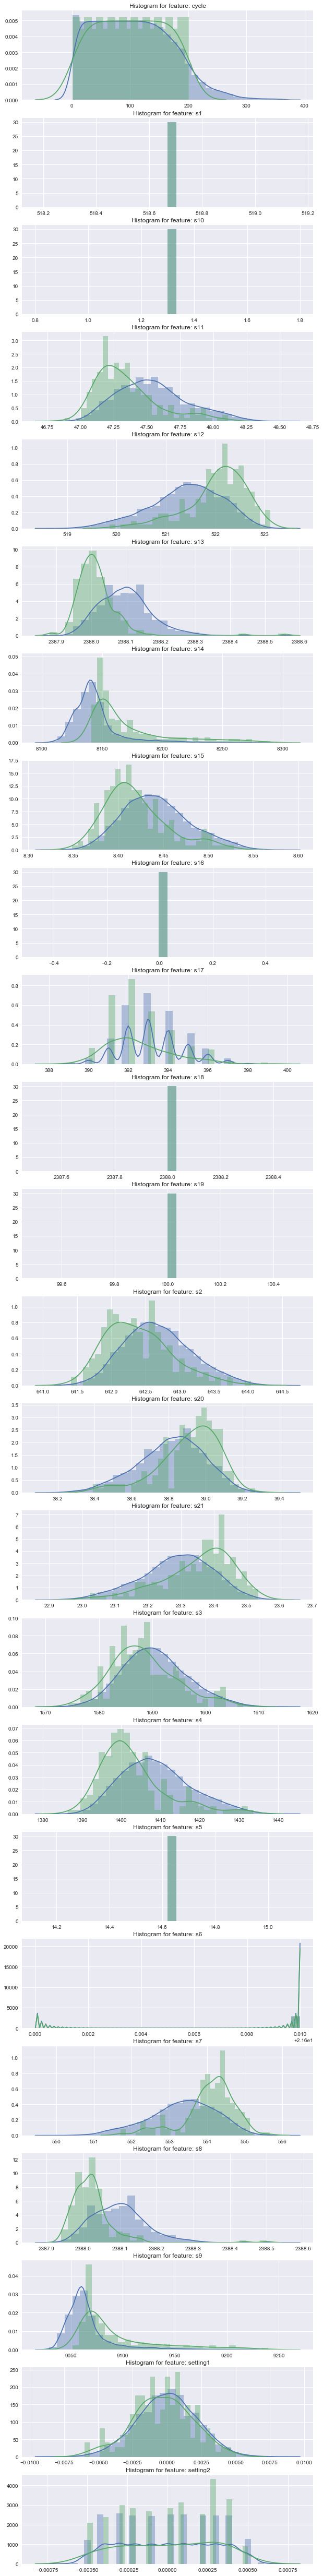

In [16]:
data = datat
e = 'Engine_9'
plot_features = num_cols
plt.figure(figsize=(10,90))
grids = gridspec.GridSpec(len(plot_features),1)
for i,j in enumerate(data[plot_features]):
    ax = plt.subplot(grids[i])
    sns.distplot(data[j][data.label == 0], bins=30)
    sns.distplot(data[j][(data.label == 0) & (data.id == e)], bins=30)
    #sns.distplot(data[j][data.label == 1], bins=30)
    ax.set_xlabel('')
    #ax.set_xlim(-2,2)
    ax.set_title('Histogram for feature: ' + str(j))
plt.show()

### 3.5. Зависимость признаков 

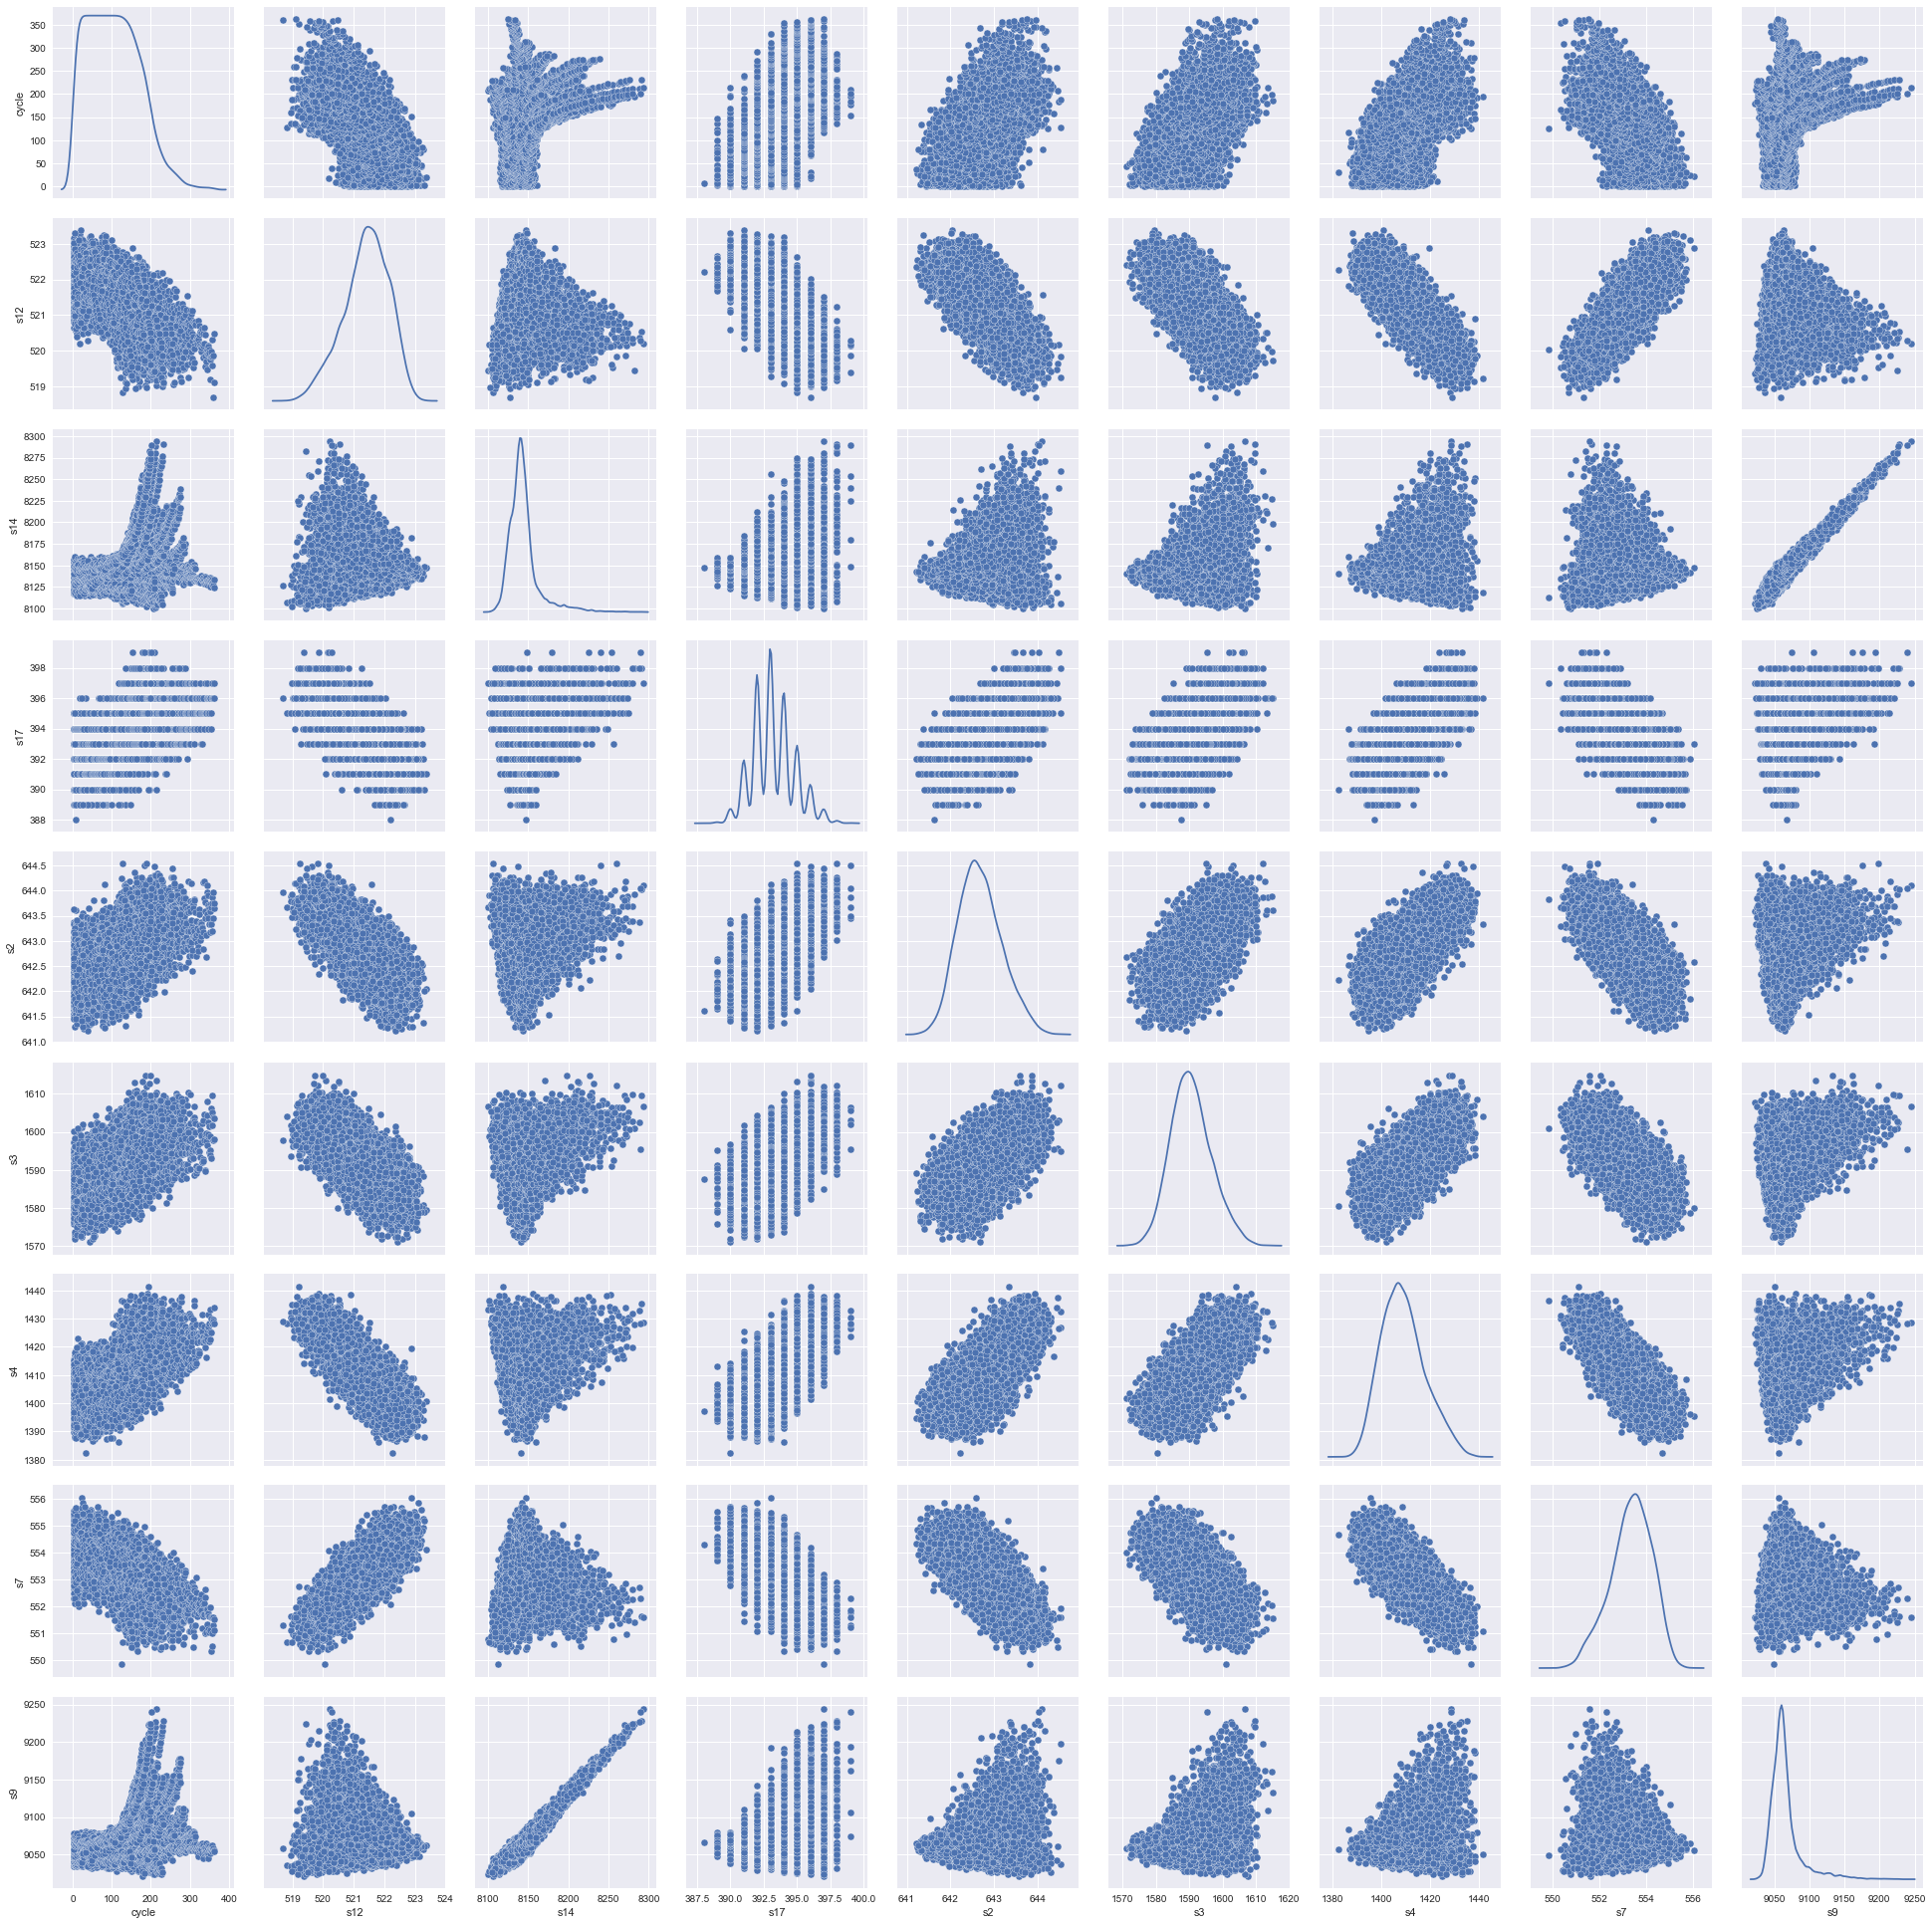

In [17]:
#data = data1[data1['id']=='Engine_10']
data = data1
plot_features = ['cycle','s12', 's14', 's17', 's2', 's3', 's4', 's7', 's9']
#X_y = pd.concat((data[plot_features], data['LABEL']), axis=1)
new_palette = sns.color_palette("Paired")
#sns.palplot(new_palette)
sns.pairplot(data, vars=plot_features, size=3, diag_kind="kde")

### 3.6. Корреляционная карта признаков
Корреляция Пирсона характеризуетсуществование линейной зависимости между прзнаками.
Есть признаки, которые имеют нулевую корреляцию со другими.

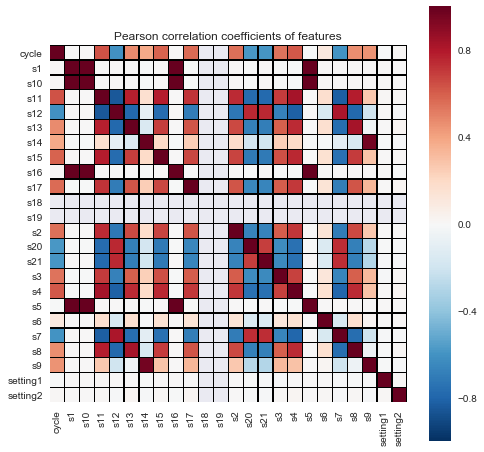

In [18]:
data = data1.drop(["id"], axis=1)
f, ax = plt.subplots(figsize=(8, 8))
plt.title('Pearson correlation coefficients of features')
sns.heatmap(data.astype(float).corr(),linewidths=0.25,vmax=1.0, square=True, linecolor='black')

In [19]:
# удалим измерения, которые являются константами
drop_columns = ['s1', 's10', 's16', 's18', 's19', 's5', 's6'] 

In [20]:
# Фильтрованные признаки
num_cols_filtered = ['s11', 's12', 's13', 's14', 's15',
       's17','s2', 's20', 's21', 's3', 's4', 's7',
       's8', 's9', 'setting1', 'setting2'] 

### 3.7. Посмотрим  на критерий Шапиро-Уилка для проверки статистической гипотезы нормальности распределений
Критерий Шапиро-Уилка используется для проверки гипотезы о том, что случайная величина распределена нормально, и является одним наиболее эффективных критериев проверки нормальности
Можно видеть, что почти все измеряемые величины, действительно, имеют нормальное распределение

In [21]:
for c in num_cols:
    f = data1[c]
    print("Feature: ", c, " ---- ", shapiro(f))

Feature:  cycle  ----  (0.9707181453704834, 0.0)
Feature:  s1  ----  (1.0, 1.0)
Feature:  s10  ----  (1.0, 1.0)
Feature:  s11  ----  (0.9832726716995239, 1.9494555950024704e-39)
Feature:  s12  ----  (0.986430287361145, 2.892272855718285e-36)
Feature:  s13  ----  (0.13093715906143188, 0.0)
Feature:  s14  ----  (0.8174232244491577, 0.0)
Feature:  s15  ----  (0.9899370670318604, 5.659265913262647e-32)
Feature:  s16  ----  (1.0, 1.0)
Feature:  s17  ----  (0.9564566016197205, 0.0)
Feature:  s18  ----  (1.0, 1.0)
Feature:  s19  ----  (1.0, 1.0)
Feature:  s2  ----  (0.9897502660751343, 3.139683697592912e-32)
Feature:  s20  ----  (0.991839587688446, 3.908527368122528e-29)
Feature:  s21  ----  (0.9913332462310791, 6.175036205999495e-30)
Feature:  s3  ----  (0.9941206574440002, 5.689672590934323e-25)
Feature:  s4  ----  (0.9859420657157898, 8.6132879547297e-37)
Feature:  s5  ----  (1.0, 1.0)
Feature:  s6  ----  (0.010095596313476562, 0.0)
Feature:  s7  ----  (0.9889432787895203, 2.70055004852340

### 4. Признаки
Посмотрим на зависимость признаков по циклам для различных моторов.
Выясняем, что степенная зависимость - это типичная закономерность в поведении показаний датчиков мотора по циклам

In [22]:
def fitfunc(p, x):
    return p[0] + p[1] * (x ** p[2])
def errfunc(p, x, y):
    return y - fitfunc(p, x)

In [23]:
def visualize_features(e,c):
    
    outliers = {}

    x = datat[datat.id == e]["cycle"]
    y = datat[datat.id == e][c]

    plt.figure(figsize=(10,10))
    qout,success = optimize.leastsq(errfunc, [mean(y),1,2], args=(x, y))
    if success:
        ya = qout[0] + qout[1]*(x**qout[2])
        y_err = y-ya
        y_std = np.sqrt((1/(len(y)-1)*sum((y-ya)**2)))
        yp95 = np.percentile(y, 95)
        print("Bias constant: {}, Sign constant: {}, Power law constant: {}".format(qout[0],qout[1],qout[2]))
        print("Standard deviation: {}, Percentile p = 95% : {}".format(y_std,yp95))
        outliers[e,c] = (x[y[(y < ya - 3*y_std) |
                             (y > ya + 3*y_std)].index].values, y[y[(y < ya - 3*y_std) 
                                                                        | (y > ya + 3*y_std)].index].values)
    else:
        print("There is no convergence: ", e, " ", c)
    plt.plot(x, y, 'b--', label=e)
    plt.plot(x, ya, 'r', label=e+'_analytical_curve')
    plt.plot(x, ya+3*y_std, 'g--', label='upper confidence edge')
    plt.plot(x, ya-3*y_std, 'y--', label='lower confidence edge')
    plt.tick_params(axis='both', which='major', labelsize=14)
    plt.xlabel("Cycle", fontsize=16)
    plt.ylabel(c, fontsize=16)
    plt.legend(loc='best', fontsize=16)
    plt.show()

    #!Eng9 "s13" abrupt change, s8

### 4.1. Отбор по дисперсии
Некоторые признаки мало вариативны, поэтому можно попробовать понизить размерность задачи, отбросив такие признаки из обучающей выборки

In [24]:
def VarianceThreshold_selector(X):
    columns = X.columns
    selector = VarianceThreshold(threshold=(0.9*(1-0.9)))
    selector.fit_transform(X)
    labels = [columns[x] for x in selector.get_support(indices=True) if x]
    return pd.DataFrame(X[labels], columns=labels)

In [25]:
num_cols_vred = VarianceThreshold_selector(data1.drop(["id"], axis=1)).columns

In [26]:
num_cols_vred

Index(['s12', 's14', 's17', 's2', 's3', 's4', 's7', 's9'], dtype='object')

###  4.2. Визуализации признаков и обучающей выборки
t_SNE популярный алгоритм, который позволяет снижать размерность ваших данных, чтобы их было проще визуализировать. Этот алгоритм может свернуть сотни измерений к всего двум, сохраняя при этом важные отношения между данными: чем ближе объекты располагаются в исходном пространстве, тем меньше расстояние между этими объектами в пространстве сокращенной размерности. Это может быть полезным для визуального анализа аутлайеров в обучающей выборке

In [27]:
df = data1[num_cols_filtered]
scaler = MinMaxScaler() # для t-sne обязательно нужна стандартизация признаков
data_sample_sc = scaler.fit_transform(df)

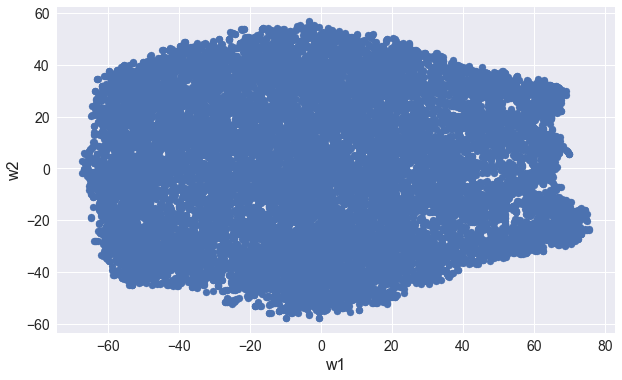

In [28]:
tsne = manifold.TSNE(n_components=2, init='pca', random_state=6)
data_2d_tsne = tsne.fit_transform(data_sample_sc)

plt.figure(figsize = (10, 6))
plt.scatter(data_2d_tsne[:,0], data_2d_tsne[:,1])
plt.tick_params(axis='both', which='major', labelsize=14)
plt.legend(loc='best')
#plt.xlim([-5000,5000])
#plt.ylim([-5000,5000])
plt.xlabel("w1", fontsize=16)
plt.ylabel("w2", fontsize=16)
plt.show()

Bias constant: 2387.9886883848812, Sign constant: 9.261322583133796e-18, Power law constant: 7.094936613928798
Standard deviation: 0.04671245925251302, Percentile p = 95% : 2388.1


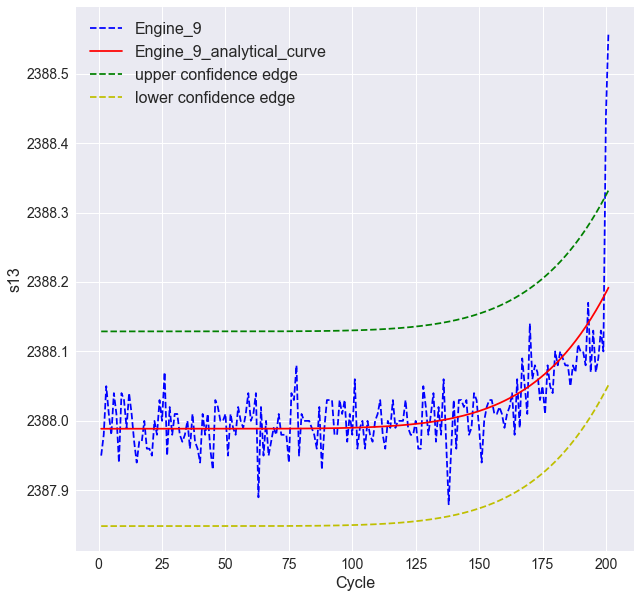

In [29]:
visualize_features("Engine_9", "s13")

Визуализируем функцию показаний датчиков мотора по циклам, вместе с аппроксимирующей функцией (степенной закон) по методу наименьших квадратов
и границами доверительного интервала (в 3 стандартных отклонения) для значений временного ряда. Замечаем, что у некоторых моторов, например, Engine_9 в показаниях s8 и s13 (который показан для примера), наблюдаются существенно аномальные значения на последних операционных циклах

### 4.1.1. Посмотрим на некоторые признаки в отдельности, но по всем моторам

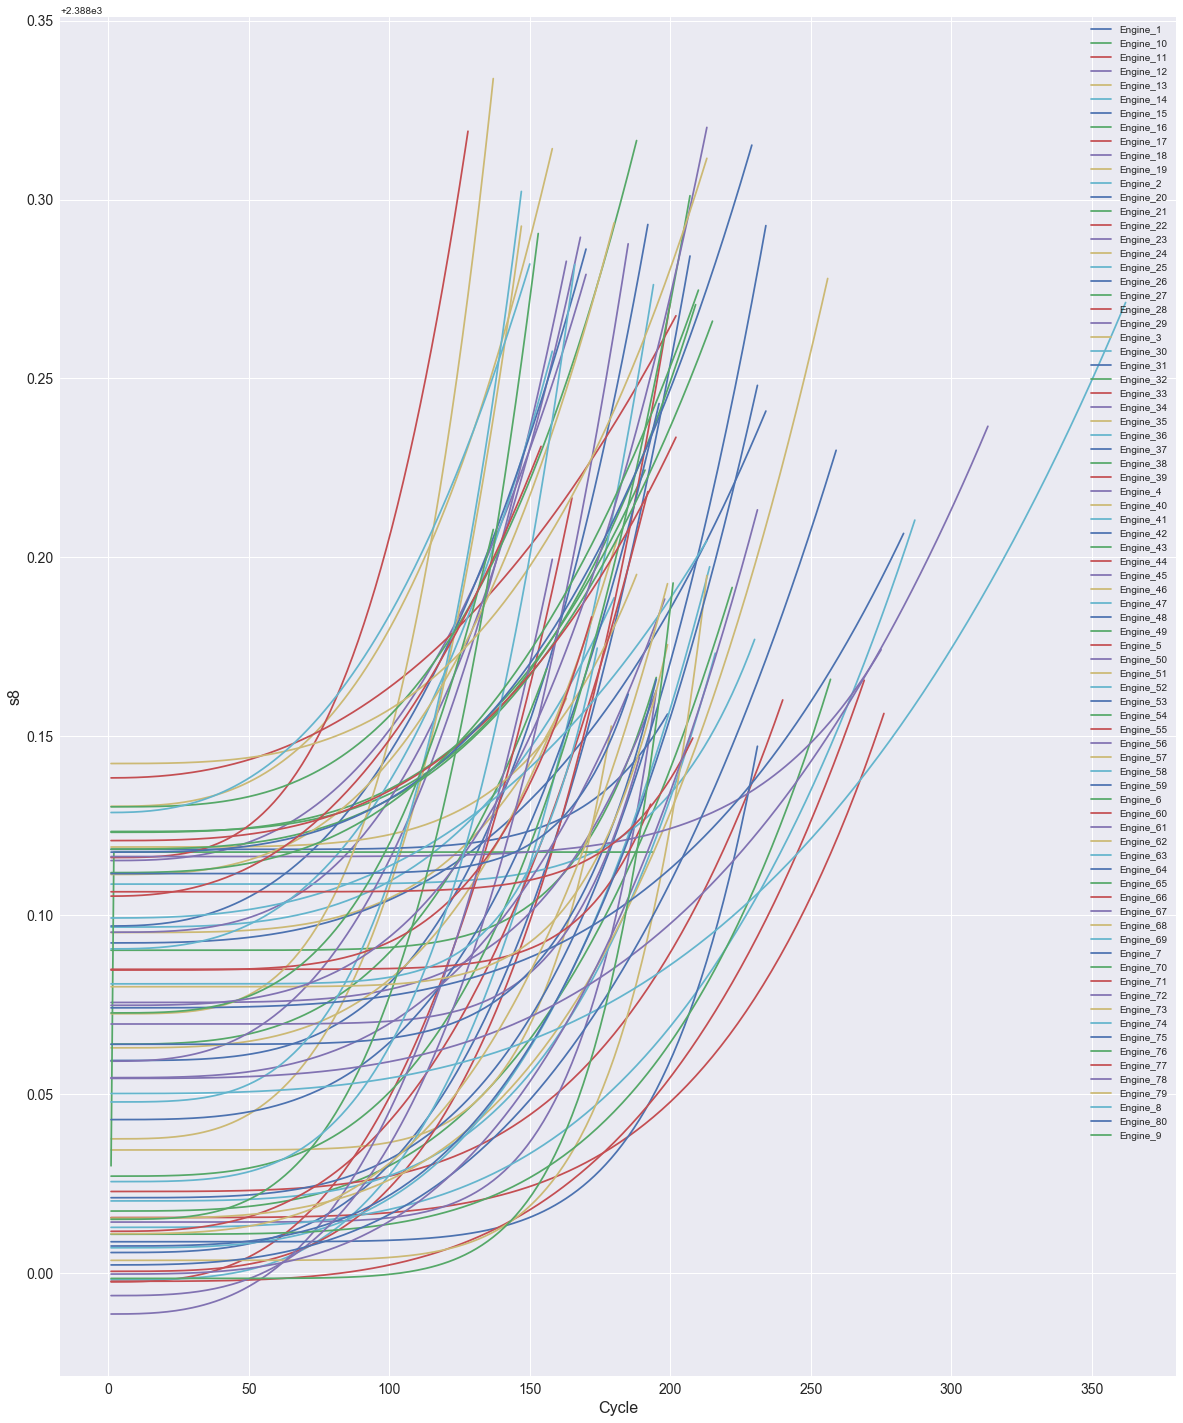

In [30]:
c = "s8"
plt.figure(figsize=(20,25))
inc = {}
for e in eng_id1:
    x = data1[data1.id == e]["cycle"]
    y = data1[data1.id == e][c]
    
    qout,success = optimize.leastsq(errfunc, [mean(y),1,2], args=(x, y))
    
    if success:
        ya = qout[0] + qout[1]*(x**qout[2])
        inc[e] = qout[2]
        plt.plot(x,ya,label=e)
    else:
        print("There is no convergence: ", e, " ", c)
        break

plt.tick_params(axis='both', which='major', labelsize=14)
plt.legend(loc='best')
#plt.xlim([0,500])
#plt.ylim([46,50])
plt.xlabel("Cycle", fontsize=16)
plt.ylabel(c, fontsize=16)
plt.show()

### Приходим к промежуточным выводам:
1. Большинство признаков - измерений датчиков ведут себя как степенная функция с добавлением высокоамплитудного случайного шума
2. Некоторые признаки принимают констанстные значения на всех объектах обучающей выборки, поэтому не информативны.
3. В некоторых временных рядах измерений ряда моторов наблюдаются существенные аномалии (больше 3 стандартных отклонений). Были замечены аномалии на последних операционных циклах, что может являться индикатором того, что мотор на следующем цикле выйдет из строя.   

### Дальнейшие подходы к выявлению аномалий:
Воспользуемся набором разноплановых подходов для взаимной верификации, посмотрим, какие baseline методы наиболее хорошо решают задачи. Отталкиваемся от следующих подходов:

1. Применение простого статистического анализа для выявления аномальных циклов кажется оправданным.
Первое предположение: Анализируем каждую последовательность измерений по циклам. Если на последних циклах, отклонение измеренной величины от типичной закономерности (например, выявленного степенного закона) превышает определенный порог (наприммер, 95-99% перцентиль или 3 стандартных отклонения), то с большой вероятностью будет поломка на следующем цикле. "Приближение квазимаркового процесса" - только существенные аномалии на последних циклах непосредственно влияют на поломку на следующем цикле. 
Второе предположение: Поломка мотора зависит от временного ряда измерений в целом, от всех его прошлых значений. Если когда-то возник сбой, например, на начальных циклах, то это повлияло на дальнейшие измерения. Другими словами, кривые измерений для моторов, склонных к поломке на следующем цикле, и нормальных моторов будут статистически различаться. Вычислим дополнительные признаки для модели, связанные со статистиками временных рядов, и будем использовать эти признаки в модели выявления аномалий.

2. Воспользуемся моделями машинного обучения без подкрепления (без учителя, тк у нас отсутствуют примеры сбоев моторов) для выявления аномальных циклов моторов в обучающей выборке. Применим 3-и наболее популярных алгоритмы выявления аномалий: Одноклассовый SVM (метод опорных векторов), древесные алгоритмы (Isolation Forest), модификация метода ближайших соседей (Local Outlier Factor). Будем брать пересечение результатов трех моделей для повышения точности идентификации аномальных циклов.

### 5. Статистический подход №1
Идентифицируем аутлайеров на последних циклах измерений датчиков (последние 5% измерений), если они там возникают, то это наиболее вероятно приведет к поломке на следующем цикле

In [38]:
def statistic_anomaly_detection(data, eng_id, std_k, percentile_k):
        #std_k = 4 # sigma-coefficient
        #percentile_k = 1 # percentile-coefficient

    for e in eng_id:

        outliers_std = {}
        outliers_percentile = {}

        for c in num_cols_filtered:

            x = data[data.id == e]["cycle"]
            y = data[data.id == e][c]

            qout,success = optimize.leastsq(errfunc, [mean(y),1,2], args=(x, y))
            if success:
                ya = qout[0] + qout[1]*(x**qout[2])
                y_err = abs(y-ya)
                y_std = np.sqrt((1/(len(y)-1)*sum((y-ya)**2)))
                y_err_p95 = np.percentile(y_err, 95)

                if y[(y < ya - std_k*y_std) | (y > ya + std_k*y_std)].any():

                    if (max(x[y[(y < ya - std_k*y_std) | (y > ya + std_k*y_std)].index].values) > max(x)*0.95):

                        outliers_std[e,c] = [x[y[(y < ya - std_k*y_std) | (y > ya + std_k*y_std)].index].values, 
                                         y[y[(y < ya - std_k*y_std) | (y > ya + std_k*y_std)].index].values, 
                                         (y_err[y[(y < ya - std_k*y_std) | 
                                                  (y > ya + std_k*y_std)].index].values*100)/np.mean(y_err)]
                    else:
                        outliers_std[e,c] = [0,0,0]
                else:
                    outliers_std[e,c] = [0,0,0] 

                if y_err[y_err > percentile_k*y_err_p95].any():

                    if (max(x[y_err[y_err > percentile_k*y_err_p95].index].values) > max(x)*0.95):

                        outliers_percentile[e,c] = [x[y_err[y_err > percentile_k*y_err_p95].index].values, 
                                                y[y_err[y_err > percentile_k*y_err_p95].index].values,
                                                (y_err[y_err > percentile_k*y_err_p95].values*100)/np.mean(y_err)]
                    else:
                        outliers_percentile[e,c] = [0,0,0]
                else:

                    outliers_percentile[e,c] = [0,0,0]


            else:
                print("There is no convergence: ", e, " ", c)
        out = pd.DataFrame(outliers_std).transpose()
        out.columns = ['cycles', 'outliers', 'prediction_errors']
        if sum(out.outliers.sum()) != 0:
            print("Engine with detected anomaly by sensors: ", e)        
    return out

In [39]:
statistic_anomaly_detection(data1, eng_id1, 5, 1) # моторы с существенными аномалиями на последних циклах

Engine with detected anomaly by sensors:  Engine_18
Engine with detected anomaly by sensors:  Engine_48
Engine with detected anomaly by sensors:  Engine_51
Engine with detected anomaly by sensors:  Engine_9


cycles            outliers  \
Engine_9 s11                0                   0   
         s12                0                   0   
         s13       [200, 201]  [2388.44, 2388.56]   
         s14                0                   0   
         s15                0                   0   
         s17                0                   0   
         s2                 0                   0   
         s20                0                   0   
         s21                0                   0   
         s3                 0                   0   
         s4                 0                   0   
         s7                 0                   0   
         s8        [200, 201]   [2388.44, 2388.5]   
         s9                 0                   0   
         setting1           0                   0   
         setting2           0                   0   

                                prediction_errors  
Engine_9 s11                                    0  
         s12                                    0  
         s13       [847.336255751, 1222.21350351]  
         s14                                    0  
         s15                                    0  
         s17                                    0  
         s2                                     0  
         s20                                    0  
         s21                                    0  
         s3                                     0  
         s4                                     0  
         s7                                     0  
         s8        [868.152277833, 1049.19430512]  
         s9                                     0  
         setting1                               0  
         setting2                               0

In [36]:
 # Пример отчета для мотора Engine_39
statistic_anomaly_detection(data1, ["Engine_39"], 3, 1)

Engine with detected anomaly by sensors:  Engine_39


cycles  outliers prediction_errors
Engine_39 s11           0         0                 0
          s12           0         0                 0
          s13           0         0                 0
          s14           0         0                 0
          s15           0         0                 0
          s17           0         0                 0
          s2            0         0                 0
          s20           0         0                 0
          s21           0         0                 0
          s3            0         0                 0
          s4            0         0                 0
          s7        [125]  [549.85]    [451.04287347]
          s8            0         0                 0
          s9            0         0                 0
          setting1      0         0                 0
          setting2      0         0                 0

### Результаты:
### Список моторов, которые наиболее вероятно выйдут из строя на следующем цикле:
Engine_18 (!!! признаки s13, s8) ,
Engine_29,
Engine_38,
Engine_48 (!!! признаки s13, s8),
Engine_51 (!!! признаки s13, s8),
Engine_9 (!!! признаки s13, s8)
### Расширенный список моторов, которые могут выйти из строя на следующем цикле:
Engine_18,
Engine_29,
Engine_38,
Engine_39,
Engine_43,
Engine_48,
Engine_51,
Engine_66,
Engine_68,
Engine_77,
Engine_9

### 5.2. Проверка
Проверим, что действительно у указанных моторов наблюдается аномальные показания датчиков на последних циклах

Bias constant: 2388.0019268531123, Sign constant: 2.7702691383387563e-18, Power law constant: 7.2157686269195285
Standard deviation: 0.04930084873827585, Percentile p = 95% : 2388.09


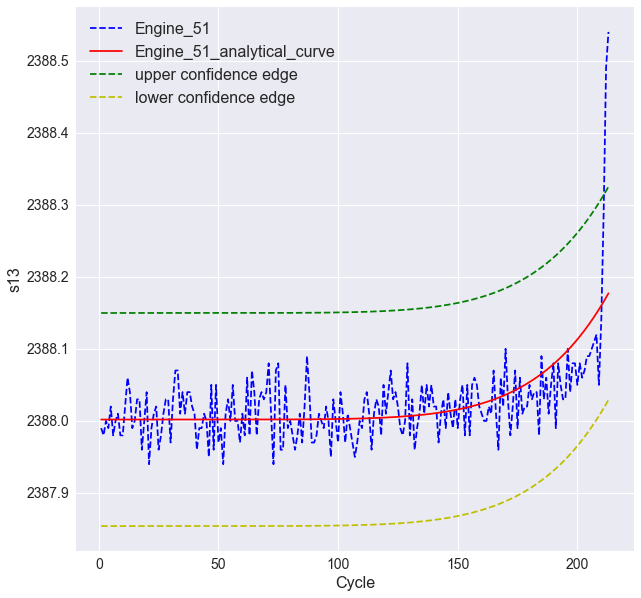

In [40]:
visualize_features("Engine_51","s13")

Bias constant: 2388.014287652306, Sign constant: 4.463418275596602e-18, Power law constant: 7.214542455271349
Standard deviation: 0.03685130114641717, Percentile p = 95% : 2388.12


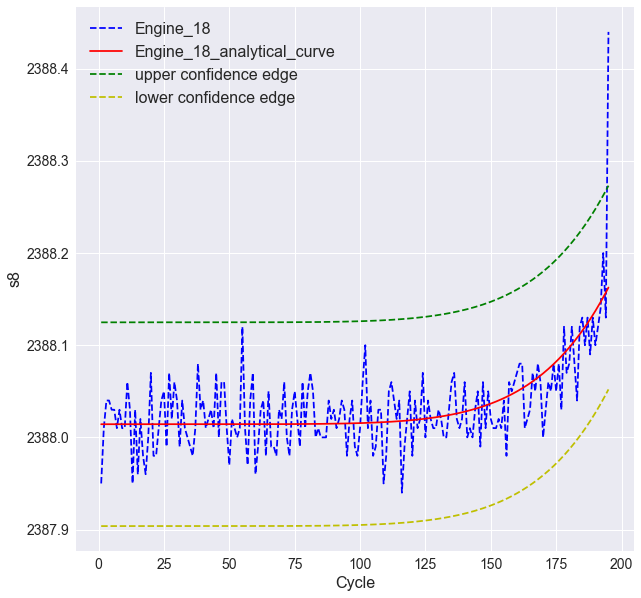

In [41]:
visualize_features("Engine_18","s8")

Bias constant: 2388.005049348614, Sign constant: 1.6285292187269377e-17, Power law constant: 6.764565720662489
Standard deviation: 0.04094377270081432, Percentile p = 95% : 2388.1


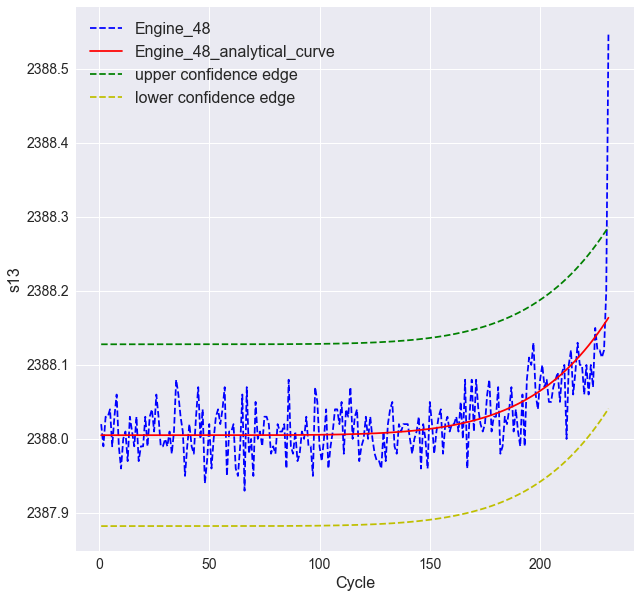

In [42]:
visualize_features("Engine_48","s13")

Bias constant: 553.2875995040204, Sign constant: -3.0984738133823104e-08, Power law constant: 3.7140628155761597
Standard deviation: 0.436881643761987, Percentile p = 95% : 553.8765


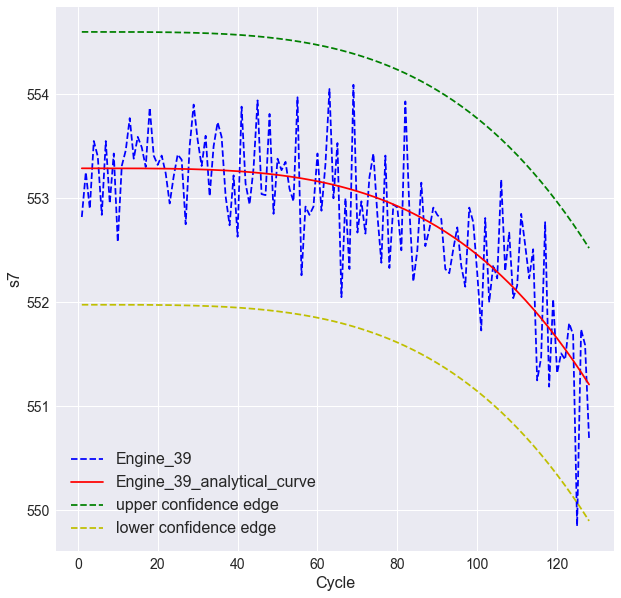

In [43]:
visualize_features("Engine_39","s7")

### 6. Статистический подход № 2. 
Проверим второе предположение: Поломка мотора зависит от временного ряда измерений в целом, от всех его прошлых значений (не будем предполагать "марковость"). Если когда-то во временном ряде возник сбой/аномалия, например, на начальных циклах, то это могло повлиять на дальнейшие измерения, что повысит вероятность сбоя на следующих циклах. Другими словами, кривые измерений для моторов, склонных к поломке на следующем цикле, и нормальных моторов будут статистически различаться. Попытаемся их разделить. Вычислим дополнительные признаки для модели, связанные со статистиками временных рядов, и будем использовать эти признаки в модели выявления аномалий.

Вычисляем статистическием характеристики по циклам

In [44]:
data = data1
eng_id = eng_id1

### 6.1. Вычисление параметров аппроксимирующей функции

In [45]:
# Функция нахождения оптимальных параметров аппрокимирующей функции по методу наименьших квадратов
def power_law_params(x, c, e):
    ans1 = {}; ans2 = {}; ans3 = {}
    def fitfunc(p, x):
        return p[0] + p[1] * (x ** p[2])
    def errfunc(p, x, y):
        return y - fitfunc(p, x)
    for i in c:
        x_ = x["cycle"]
        y_ = x[i]
        q, success = optimize.leastsq(errfunc, [mean(y_), 1, 2], args=(x_, y_))
        if success:
            ans1[e,i] = q[0]
            ans2[e,i] = q[1]
            ans3[e,i] = q[2]
        k1 = pd.Series(list(ans1.values()))
        k2 = pd.Series(list(ans2.values()))
        k3 = pd.Series(list(ans3.values()))
    return k1,k2,k3

### 6.2. Расчет статистических характеристик признаков по циклам

In [46]:
for e in eng_id:
        # Рассчитаем стандартные статистики мин, макс, среднее, дисперсия
        stat_min = data[data['id']==e][num_cols].min(axis=0)
        stat_min.index = [i+'_min' for i in num_cols]
        stat_max = data[data['id']==e][num_cols].max(axis=0)
        stat_max.index = [i+'_max' for i in num_cols]
        stat_aver = data[data['id']==e][num_cols].mean(axis=0)
        stat_aver.index = [i+'_aver' for i in num_cols]
        stat_std = data[data['id']==e][num_cols].std(axis=0)
        stat_std.index = [i+'_std' for i in num_cols]
        # Рассчитаем асимметрию и эксцесс функции распределения
        stat_skew = pd.Series(stats.skew(data[data['id']==e][num_cols]))
        stat_skew.index = [i+'_skew' for i in num_cols]
        stat_kurtosis = pd.Series(stats.kurtosis(data[data['id']==e][num_cols]))
        stat_kurtosis.index = [i+'_kurtosis' for i in num_cols]
        # Рассчитаем 5 и 95% перцентили распределения
        stat_q5 = data[data['id']==e][num_cols].quantile(0.05)
        stat_q5.index = [i+'_q5' for i in num_cols]
        stat_q95 = data[data['id']==e][num_cols].quantile(0.95)
        stat_q95.index = [i+'_q95' for i in num_cols]
        # Рассчитаем константы степенного закона
        stat_power1, stat_power2, stat_power3 = power_law_params(data[data['id']==e][num_cols],num_cols,e)
        stat_power1.index = [i+'_power_k1' for i in num_cols]
        stat_power2.index = [i+'_power_k2' for i in num_cols]
        stat_power3.index = [i+'_power_k3' for i in num_cols]
        if e == 'Engine_1':
            data_stat = pd.concat([stat_min, stat_max, stat_aver, stat_std, stat_skew, stat_kurtosis, stat_q5, stat_q95,
                                   stat_power1, stat_power2, stat_power3], axis = 0)
        else:
            data_stati = pd.concat([stat_min, stat_max, stat_aver, stat_std, stat_skew, stat_kurtosis, stat_q5, stat_q95,
                                  stat_power1, stat_power2, stat_power3], axis = 0)
            data_stat = pd.concat([data_stat, data_stati], axis = 1)
        print(e, ' --- is done!')
data_stat = data_stat.transpose()
data_stat.index = eng_id

Engine_1  --- is done!
Engine_10  --- is done!
Engine_11  --- is done!
Engine_12  --- is done!
Engine_13  --- is done!
Engine_14  --- is done!
Engine_15  --- is done!
Engine_16  --- is done!
Engine_17  --- is done!
Engine_18  --- is done!
Engine_19  --- is done!
Engine_2  --- is done!
Engine_20  --- is done!
Engine_21  --- is done!
Engine_22  --- is done!
Engine_23  --- is done!
Engine_24  --- is done!
Engine_25  --- is done!
Engine_26  --- is done!
Engine_27  --- is done!
Engine_28  --- is done!
Engine_29  --- is done!
Engine_3  --- is done!
Engine_30  --- is done!
Engine_31  --- is done!
Engine_32  --- is done!
Engine_33  --- is done!
Engine_34  --- is done!
Engine_35  --- is done!
Engine_36  --- is done!
Engine_37  --- is done!
Engine_38  --- is done!
Engine_39  --- is done!
Engine_4  --- is done!
Engine_40  --- is done!
Engine_41  --- is done!
Engine_42  --- is done!
Engine_43  --- is done!
Engine_44  --- is done!
Engine_45  --- is done!
Engine_46  --- is done!
Engine_47  --- is do

In [ ]:
#data_stat.to_csv("data_stat_train.csv")

In [289]:
data_stat1 = pd.read_csv("data_stat_train.csv")
data_stat2 = pd.read_csv("data_stat_test.csv")

In [290]:
data_stat1['flag'] = 0.0
data_stat2['flag'] = 1.0

In [291]:
data_stat = pd.concat([data_stat1, data_stat2], axis=0).reset_index()

In [292]:
data_stat['id'] = data_stat['Unnamed: 0']

In [293]:
data_stat = data_stat.drop(['index', 'Unnamed: 0'], axis=1)

In [304]:
li  = data_stat.drop(["id"], axis=1).columns

In [328]:
li = ['s14_min', 's17_min', 's3_min', 's4_min', 's9_min', 'cycle_max',
       's12_max', 's14_max', 's17_max', 's3_max', 's4_max', 's7_max', 's9_max',
       'cycle_aver', 's14_aver', 's17_aver', 's3_aver', 's4_aver', 's9_aver',
       'cycle_std', 's14_std', 's3_std', 's4_std', 's9_std', 's10_skew',
       's13_skew', 's14_skew', 's16_skew', 's5_skew', 's6_skew', 's8_skew',
       's9_skew', 's10_kurtosis', 's11_kurtosis', 's13_kurtosis',
       's14_kurtosis', 's2_kurtosis', 's3_kurtosis', 's4_kurtosis',
       's5_kurtosis', 's6_kurtosis', 's7_kurtosis', 's8_kurtosis',
       's9_kurtosis', 'cycle_q5', 's14_q5', 's17_q5', 's3_q5', 's4_q5',
       's9_q5', 'cycle_q95', 's12_q95', 's14_q95', 's3_q95', 's4_q95',
       's7_q95', 's9_q95', 's12_power_k1', 's14_power_k1', 's17_power_k1',
       's3_power_k1', 's4_power_k1', 's7_power_k1', 's9_power_k1',
       's14_power_k2', 's9_power_k2', 's11_power_k3', 's12_power_k3',
       's13_power_k3', 's14_power_k3', 's15_power_k3', 's17_power_k3',
       's2_power_k3', 's20_power_k3', 's21_power_k3', 's3_power_k3',
       's4_power_k3', 's6_power_k3', 's7_power_k3', 's8_power_k3',
       's9_power_k3', 'setting1_power_k3', 'setting2_power_k3']

In [54]:
### 6.3. Анализ  

In [55]:
for e in eng_id1:
    for c in li:
        v = data_stat[(data_stat.id == e) & (data_stat.flag == 0.0)][c].values[0]
        i = data_stat[(data_stat.id == e) & (data_stat.flag == 0.0)][c].index
        minv = data_stat[(data_stat.id != e) & (data_stat.flag == 0.0)][c].min()
        maxv = data_stat[(data_stat.id != e) & (data_stat.flag == 0.0)][c].max()
        if ((v < minv ) | (v > maxv)): 
            data_stat.set_value(i,c,True)
        else:
            data_stat.set_value(i,c,False)

In [56]:
res = pd.concat([data_stat[data_stat.flag == 0.0][li].sum(axis=1),data_stat[data_stat.flag == 0.0]["id"]], axis=1)

In [57]:
res.columns = ['sum_abn','id']

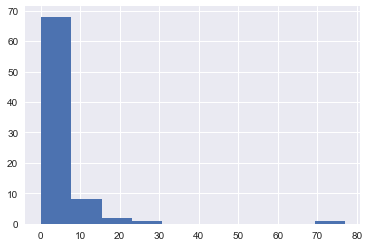

In [58]:
# Гистограмма числа аномалий в признаках по моторам
res.sum_abn.hist()

In [59]:
res['pseudo_proba'] = res['sum_abn'] - res['sum_abn'].mean()
res['pseudo_proba'] = round((res['pseudo_proba'] - res['pseudo_proba'].min()) / (res['pseudo_proba'].max() -
                                                                         res['pseudo_proba'].min()),2)

### 6.2. Результат: 
Моторы, ранжированне по кол-ву аномалий среди статистических признаков для данного мотора

In [60]:
res[res['pseudo_proba'] > res['pseudo_proba'].mean()].sort_values(by=['pseudo_proba'], ascending=False)

sum_abn         id  pseudo_proba
79     77.0   Engine_9          1.00
78     26.0  Engine_80          0.34
77     18.0   Engine_8          0.23
46     17.0  Engine_51          0.22
76     11.0  Engine_79          0.14
66     11.0   Engine_7          0.14
73     11.0  Engine_76          0.14
72      9.0  Engine_75          0.12
75      9.0  Engine_78          0.12
70      9.0  Engine_73          0.12
34      8.0  Engine_40          0.10
50      8.0  Engine_55          0.10
39      7.0  Engine_45          0.09
57      7.0  Engine_61          0.09
14      6.0  Engine_22          0.08
62      6.0  Engine_66          0.08
44      6.0   Engine_5          0.08
65      6.0  Engine_69          0.08
67      5.0  Engine_70          0.06
33      5.0   Engine_4          0.06
42      5.0  Engine_48          0.06

In [67]:
data_stat[(data_stat.flag == 0.0) & (data_stat.id == "Engine_9")]

cycle_min  s1_min  s10_min  s11_min  s12_min  s13_min  s14_min  s15_min  \
79        1.0  518.67      1.3    46.88   519.86  2387.88  8140.94   8.3487   

    s16_min  s17_min    ...     s4_power_k3  s5_power_k3  s6_power_k3  \
79     0.03    389.0    ...        5.271763     1.275186     4.079316   

    s7_power_k3  s8_power_k3  s9_power_k3  setting1_power_k3  \
79      6.20437     7.357462     4.983704           0.257414   

    setting2_power_k3  flag        id  
79           0.000513   0.0  Engine_9  

[1 rows x 266 columns]

In [79]:
#### Проверка, что действительно распредение по выборкам для Engine_9 
#### всех остальных моторов статистически сильно различается Критерий Колмогорова-Смирнова
data = datat
kk = {}
e = "Engine_9"
for c in num_cols_filtered:
    v = stats.ks_2samp(data[c][(data.label == 0.0) & (data.id != e)], data[c][(data.label == 0.0) & (data.id == e)])
    kk[c] = [v[0], v[1]]
    sorted_kk = sorted(kk.items(), key=operator.itemgetter(1), reverse=False) 
pd.DataFrame(sorted_kk, columns=['feature','statistics&p-value'])

feature                   statistics&p-value
0   setting2    [0.0329703056531, 0.980523618642]
1   setting1    [0.0837320581631, 0.117522628268]
2         s3   [0.21011901027, 3.55070100116e-08]
3        s17  [0.246957469664, 3.92947315361e-11]
4         s2  [0.262580240543, 1.57345594894e-12]
5        s20  [0.270187307798, 3.05751742074e-13]
6        s21  [0.317485172494, 4.03391133202e-18]
7        s15  [0.318420447177, 3.17187554447e-18]
8         s4   [0.35356723317, 2.26486132774e-22]
9        s11   [0.38468134948, 2.10170105731e-26]
10       s12  [0.437150071941, 5.65714730696e-34]
11        s7   [0.45781321166, 3.20714101315e-37]
12        s9  [0.514234999315, 7.54923971704e-47]
13        s8  [0.559167830297, 2.57481261187e-55]
14       s13  [0.563157107729, 4.21447067223e-56]
15       s14  [0.593791099719, 2.52791613077e-62]

p-value действительно для большинства измерений очень низок, поэтому гипотеза о "непохожести" двух распределений может быть принята

### 6.3. Визуализация обучающей выборки в новом признаковом пространстве

In [80]:
df = data_stat[data_stat.flag==0.0][li]
scaler = MinMaxScaler() # для t-sne обязательно нужно шкалирование признаков
data_sample_sc = scaler.fit_transform(df)

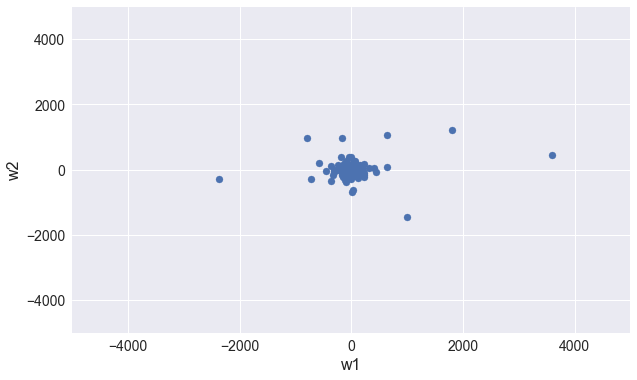

In [89]:
tsne = manifold.TSNE(n_components=3, init='pca', random_state=2017)
data_2d_tsne = tsne.fit_transform(data_sample_sc)

plt.figure(figsize = (10, 6))
plt.scatter(data_2d_tsne[:,0], data_2d_tsne[:,1])
plt.tick_params(axis='both', which='major', labelsize=14)
plt.legend(loc='best')
plt.xlim([-5000,5000])
plt.ylim([-5000,5000])
plt.xlabel("w1", fontsize=16)
plt.ylabel("w2", fontsize=16)
plt.show()

В пространстве пониженной размерности можно наблюдать центральное ядро (кластер), наполненное точками - нормальные режимы работы моторов, и объекты - аутлайеры. Можно добиться лучшей разделимости на визуализации, если провести более детальный отбор признаков

### 6.4. Определение аномальных объектов по статистикам (модели машинного обучения)
Применим модель машинного обучения с подкреплением на основе решающих деревьев (Isolation Forest), чтобы выделить объекты (моторы), которые демонстрируют отличное от нормального поведения большинства моторов, что вероятно свидетельствуют об их аномальности и скорой поломке.

In [90]:
clf4 = IsolationForest(n_estimators=50, max_samples='auto', contamination=0.05, 
                       max_features=0.5, bootstrap=True, n_jobs=1, random_state=2017, verbose=0)

In [91]:
clf4.fit(data_sample_sc)
y_if_pred = clf4.predict(data_sample_sc)

In [92]:
a = list(y_if_pred)
indices = [i for i, x in enumerate(a) if x == -1]
data_stat[data_stat.flag==0.0][li+['id']].ix[indices]

s14_min  s17_min   s3_min   s4_min   s9_min  cycle_max  s12_max  s14_max  \
9   8136.89    390.0  1576.32  1389.32  9051.44      195.0   523.20  8282.50   
42  8137.78    390.0  1572.34  1389.40  9057.89      231.0   522.97  8290.25   
46  8138.56    389.0  1573.22  1388.02  9057.07      213.0   523.01  8293.72   
79  8140.94    389.0  1574.30  1386.43  9051.59      201.0   523.12  8289.63   

    s17_max   s3_max    ...      s21_power_k3  s3_power_k3  s4_power_k3  \
9     398.0  1609.52    ...          5.199957     4.467218     4.824467   
42    398.0  1609.54    ...          4.918861     5.071446     4.978106   
46    398.0  1609.75    ...          5.473763     3.554743     5.131779   
79    399.0  1607.04    ...          3.809223     3.388256     5.271763   

    s6_power_k3  s7_power_k3  s8_power_k3  s9_power_k3  setting1_power_k3  \
9      0.163969     6.162265     7.214542     4.884816           0.000250   
42     0.788444     6.093859     6.978221     4.896589           0.000542   
46     1.770031     4.307435     7.228063     5.076385           1.771531   
79     4.079316     6.204370     7.357462     4.983704           0.257414   

    setting2_power_k3         id  
9           -1.418993  Engine_18  
42           0.782156  Engine_48  
46           0.000230  Engine_51  
79           0.000513   Engine_9  

[4 rows x 84 columns]

### 6.5. Результат:
#### Моторы с id: Engine_18, Engine_48, Engine_51, Engine_9 статистически наиболее отличаются от всех остальных.
Отметим, что эти моторы уже были размечены как "рискованные" с помощью предыдущей оценки распределений признаков

### 7. Методы машинного обучения без подкрепления
Воспользуемся моделями машинного обучения без подкрепления (без учителя, тк у нас отсутствуют примеры сбоев моторов) для выявления аномальных циклов моторов в обучающей выборке. Применим 3-и наболее популярных алгоритмы выявления аномалий: Одноклассовый SVM (метод опорных векторов), древесные алгоритмы (Isolation Forest), модификация метода ближайших соседей (Local Outlier Factor). Будем брать пересечение результатов трех моделей для повышения точности идентификации аномальных циклов.

In [93]:
num_cols = ['cycle','s1', 's10', 's11', 's12', 's13', 's14', 's15', 's16',
       's17', 's18', 's19', 's2', 's20', 's21', 's3', 's4', 's5', 's6', 's7',
       's8', 's9', 'setting1', 'setting2']
# набор признаков для обучения моделей, пока baseline модели проверим на всех признаках

In [94]:
# Фильтрованные признаки
num_cols_filtered = ['cycle', 's11', 's12', 's13', 's14', 's15',
       's17','s2', 's20', 's21', 's3', 's4', 's7',
       's8', 's9', 'setting1', 'setting2'] 

In [95]:
# Отобранные по дисперсии
num_cols_vred = ['cycle', 's12', 's14', 's17', 's2', 's3', 's4', 's7', 's9']

In [96]:
data_sample = data1[num_cols_filtered]

### 7.1. Масштабируем обучающую выборку
Используем масштабирование на отрезок [0,1] для выравнивания масштабы признаков

In [97]:
scaler_minmax = MinMaxScaler() 
data_sample_sc = scaler_minmax.fit_transform(data_sample)

### 7.2. Одноклассовый SVM
На графике взаимосвязи признаков видно, что в двумерном подпространстве объекты образуют сферические/элипсоидальные скопления.
Поэтому логично применить Гауссову функцию в качестве ядра для метода опорных векторов.
Остальные параметры модели подбираются экспериментальным способом на основе анализа результатов

In [98]:
clf_svm = svm.OneClassSVM(kernel="rbf", nu = 0.01, random_state=1) 

In [99]:
clf_svm.fit(data_sample_sc)
y_svm_pred = clf_svm.predict(data_sample_sc)

In [100]:
data_sample.head()

cycle    s11     s12      s13      s14     s15  s17      s2    s20  \
0      1  47.47  521.66  2388.02  8138.62  8.4195  392  641.82  39.06   
1      2  47.49  522.28  2388.07  8131.49  8.4318  392  642.15  39.00   
2      3  47.27  522.42  2388.03  8133.23  8.4178  390  642.35  38.95   
3      4  47.13  522.86  2388.08  8133.83  8.3682  392  642.35  38.88   
4      5  47.28  522.19  2388.04  8133.80  8.4294  393  642.37  38.90   

       s21       s3       s4      s7       s8       s9  setting1  setting2  
0  23.4190  1589.70  1400.60  554.36  2388.06  9046.19   -0.0007   -0.0004  
1  23.4236  1591.82  1403.14  553.75  2388.04  9044.07    0.0019   -0.0003  
2  23.3442  1587.99  1404.20  554.26  2388.08  9052.94   -0.0043    0.0003  
3  23.3739  1582.79  1401.87  554.45  2388.11  9049.48    0.0007    0.0000  
4  23.4044  1582.85  1406.22  554.00  2388.06  9055.15   -0.0019   -0.0002

In [101]:
(y_svm_pred == -1).sum()

162

### 7.2.2. Визуализация аутлайеров
Визуализируем аутлайеров (красные точки) среди нормальных объектов (синие точки) обучающей выборке в двух измерениях

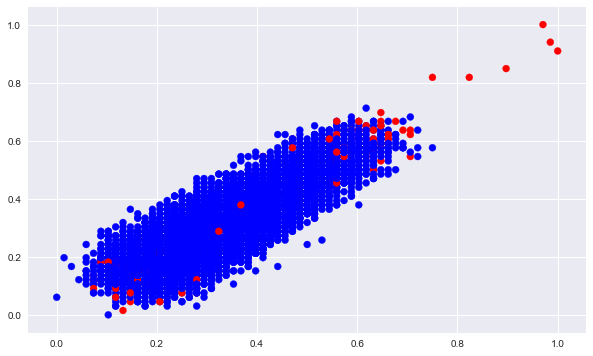

In [102]:
colors = ListedColormap(['red', 'blue'])
plt.figure(figsize = (10, 6))
plt.scatter(data_sample_sc[:,3], data_sample_sc[:,13], c = y_svm_pred, cmap = colors)
plt.legend(loc='best')
plt.show()

### 7.2.3. Результаты
Список объектов "Моторы и циклы", которые модель разметила как аномальные

In [103]:
a = list(y_svm_pred)
indices = [i for i, x in enumerate(a) if x == -1]
svm_res_train = data1.ix[indices]
svm_res_train

id  cycle      s1  s10    s11     s12      s13      s14     s15  \
219    Engine_10     28  518.67  1.3  47.13  522.41  2387.99  8133.56  8.3943   
415    Engine_11      2  518.67  1.3  47.18  522.33  2388.04  8138.28  8.3643   
986    Engine_13    163  518.67  1.3  48.22  519.76  2388.16  8211.76  8.5477   
1167   Engine_15      1  518.67  1.3  46.98  522.88  2388.00  8142.23  8.4102   
1175   Engine_15      9  518.67  1.3  47.01  522.14  2387.99  8136.59  8.3748   
1184   Engine_15     18  518.67  1.3  47.14  522.77  2387.98  8137.89  8.3908   
1196   Engine_15     30  518.67  1.3  47.06  523.06  2388.03  8143.79  8.3799   
1204   Engine_15     38  518.67  1.3  47.09  522.98  2388.03  8145.89  8.3884   
1580   Engine_16    207  518.67  1.3  48.20  519.29  2388.27  8133.60  8.5595   
1581   Engine_16    208  518.67  1.3  48.20  519.64  2388.25  8137.23  8.5419   
1583   Engine_17      1  518.67  1.3  47.25  522.19  2387.98  8146.09  8.3859   
1855   Engine_17    273  518.67  1.3  48.23  520.09  2388.13  8231.94  8.5549   
1857   Engine_17    275  518.67  1.3  47.97  519.26  2388.15  8229.73  8.5472   
1858   Engine_17    276  518.67  1.3  48.06  520.22  2388.12  8238.26  8.5171   
1865   Engine_18      7  518.67  1.3  47.14  522.27  2388.05  8151.27  8.4312   
2050   Engine_18    192  518.67  1.3  48.10  520.53  2388.18  8268.81  8.5372   
2051   Engine_18    193  518.67  1.3  48.30  520.36  2388.15  8273.15  8.5429   
2052   Engine_18    194  518.67  1.3  48.14  520.23  2388.12  8269.40  8.4945   
2053   Engine_18    195  518.67  1.3  48.01  519.44  2388.39  8282.50  8.5132   
2211   Engine_19    158  518.67  1.3  48.23  519.22  2388.33  8117.14  8.5343   
2212    Engine_2      1  518.67  1.3  46.93  522.33  2388.06  8137.72  8.3905   
2215    Engine_2      4  518.67  1.3  47.10  522.49  2387.93  8140.44  8.4018   
2216    Engine_2      5  518.67  1.3  47.25  522.27  2387.94  8136.67  8.3867   
2217    Engine_2      6  518.67  1.3  47.05  522.80  2387.99  8133.65  8.3800   
2220    Engine_2      9  518.67  1.3  47.14  522.40  2387.98  8145.29  8.3868   
2221    Engine_2     10  518.67  1.3  47.21  521.99  2387.97  8138.64  8.3982   
2223    Engine_2     12  518.67  1.3  47.13  521.94  2387.97  8136.49  8.3925   
2232    Engine_2     21  518.67  1.3  47.04  522.58  2388.01  8136.57  8.3954   
2237    Engine_2     26  518.67  1.3  47.12  522.80  2388.00  8137.27  8.3472   
2239    Engine_2     28  518.67  1.3  46.99  522.68  2387.93  8136.55  8.3734   
...          ...    ...     ...  ...    ...     ...      ...      ...     ...   
13382  Engine_69    362  518.67  1.3  48.02  519.12  2388.33  8124.27  8.5126   
14193  Engine_72    207  518.67  1.3  48.26  519.44  2388.32  8099.94  8.5239   
14195  Engine_72    209  518.67  1.3  48.23  519.86  2388.26  8104.82  8.5523   
14199  Engine_72    213  518.67  1.3  48.17  519.48  2388.36  8103.27  8.5519   
14407  Engine_73    208  518.67  1.3  48.33  519.78  2388.27  8113.46  8.5484   
14410  Engine_73    211  518.67  1.3  48.15  519.43  2388.33  8112.61  8.5185   
14578  Engine_74    166  518.67  1.3  48.07  519.52  2388.25  8123.87  8.5309   
14804  Engine_75    226  518.67  1.3  48.18  519.55  2388.30  8114.40  8.4952   
14806  Engine_75    228  518.67  1.3  48.08  519.24  2388.32  8108.51  8.5158   
15172  Engine_78      1  518.67  1.3  47.00  522.48  2387.96  8139.23  8.3303   
15173  Engine_78      2  518.67  1.3  47.23  522.87  2387.99  8144.53  8.4060   
15174  Engine_78      3  518.67  1.3  47.12  522.93  2388.07  8138.47  8.3995   
15175  Engine_78      4  518.67  1.3  47.04  522.10  2388.01  8140.27  8.3548   
15176  Engine_78      5  518.67  1.3  46.90  521.95  2387.99  8140.12  8.4112   
15179  Engine_78      8  518.67  1.3  47.01  522.92  2388.02  8140.22  8.3638   
15183  Engine_78     12  518.67  1.3  47.22  522.19  2388.00  8141.20  8.3806   
15200  Engine_78     29  518.67  1.3  47.10  522.60  2387.97  8141.89  8.3835   
15203  Engine_78     32  518.67  1.3  47.06  

### 7.3. Модель на основе решающих деревьев  (Isolation Forest)

In [104]:
clf_if = IsolationForest(n_estimators=50, max_samples='auto', contamination=0.01, 
                       max_features=0.5, bootstrap=True, n_jobs=1, random_state=2017, verbose=0)

In [105]:
clf_if.fit(data_sample_sc)
y_if_pred = clf_if.predict(data_sample_sc)

In [106]:
a = list(y_if_pred)

In [107]:
indices = [i for i, x in enumerate(a) if x == -1]

### 7.3.2. Результаты
Список объектов "Моторы и циклы", которые модель разметила как аномальные

In [108]:
iforest_res_train = data1.ix[indices]
iforest_res_train

id  cycle      s1  s10    s11     s12      s13      s14     s15  \
652    Engine_11    239  518.67  1.3  48.24  520.07  2388.17  8218.60  8.4947   
982    Engine_13    159  518.67  1.3  48.11  520.50  2388.20  8212.93  8.5540   
986    Engine_13    163  518.67  1.3  48.22  519.76  2388.16  8211.76  8.5477   
1369   Engine_15    203  518.67  1.3  48.10  519.60  2388.32  8121.62  8.4912   
1372   Engine_15    206  518.67  1.3  48.19  520.13  2388.33  8121.68  8.5487   
1580   Engine_16    207  518.67  1.3  48.20  519.29  2388.27  8133.60  8.5595   
1581   Engine_16    208  518.67  1.3  48.20  519.64  2388.25  8137.23  8.5419   
1849   Engine_17    267  518.67  1.3  47.93  520.84  2388.18  8215.02  8.5067   
1850   Engine_17    268  518.67  1.3  47.91  520.16  2388.10  8219.37  8.5400   
1851   Engine_17    269  518.67  1.3  48.14  520.54  2388.21  8226.28  8.4907   
1853   Engine_17    271  518.67  1.3  48.09  520.52  2388.15  8228.00  8.4998   
1855   Engine_17    273  518.67  1.3  48.23  520.09  2388.13  8231.94  8.5549   
1856   Engine_17    274  518.67  1.3  48.09  519.77  2388.16  8232.28  8.5197   
1857   Engine_17    275  518.67  1.3  47.97  519.26  2388.15  8229.73  8.5472   
1858   Engine_17    276  518.67  1.3  48.06  520.22  2388.12  8238.26  8.5171   
2048   Engine_18    190  518.67  1.3  47.97  520.14  2388.11  8263.06  8.5376   
2049   Engine_18    191  518.67  1.3  47.87  520.25  2388.13  8260.29  8.5102   
2050   Engine_18    192  518.67  1.3  48.10  520.53  2388.18  8268.81  8.5372   
2051   Engine_18    193  518.67  1.3  48.30  520.36  2388.15  8273.15  8.5429   
2052   Engine_18    194  518.67  1.3  48.14  520.23  2388.12  8269.40  8.4945   
2053   Engine_18    195  518.67  1.3  48.01  519.44  2388.39  8282.50  8.5132   
2211   Engine_19    158  518.67  1.3  48.23  519.22  2388.33  8117.14  8.5343   
2498    Engine_2    287  518.67  1.3  48.12  519.81  2388.21  8175.57  8.5365   
2729   Engine_20    231  518.67  1.3  48.41  519.74  2388.22  8146.48  8.4800   
2926   Engine_21    194  518.67  1.3  48.16  520.48  2388.21  8231.47  8.5032   
2927   Engine_21    195  518.67  1.3  48.04  520.26  2388.19  8224.87  8.5197   
3129   Engine_22    202  518.67  1.3  48.16  519.31  2388.30  8130.05  8.5361   
3439   Engine_24    142  518.67  1.3  47.90  520.09  2388.24  8124.07  8.5366   
3440   Engine_24    143  518.67  1.3  48.12  519.63  2388.22  8124.72  8.5327   
3441   Engine_24    144  518.67  1.3  48.28  519.56  2388.30  8116.55  8.5311   
...          ...    ...     ...  ...    ...     ...      ...      ...     ...   
11866  Engine_63    170  518.67  1.3  48.12  519.67  2388.12  8228.90  8.4922   
11868  Engine_63    172  518.67  1.3  48.17  520.47  2388.15  8235.13  8.5118   
11869  Engine_63    173  518.67  1.3  48.28  519.97  2388.14  8240.39  8.5099   
12150  Engine_64    280  518.67  1.3  48.06  520.11  2388.27  8175.60  8.5413   
12153  Engine_64    283  518.67  1.3  48.15  519.54  2388.22  8181.59  8.5458   
13017  Engine_68    196  518.67  1.3  48.12  520.43  2388.11  8221.66  8.5285   
13019  Engine_68    198  518.67  1.3  48.16  519.98  2388.18  8226.67  8.5263   
13020  Engine_68    199  518.67  1.3  48.16  519.72  2388.14  8226.34  8.5196   
13775  Engine_70    134  518.67  1.3  48.07  519.38  2388.18  8172.19  8.5328   
13777  Engine_70    136  518.67  1.3  48.21  519.77  2388.25  8165.57  8.5529   
13984  Engine_71    206  518.67  1.3  48.15  520.27  2388.16  8215.87  8.5348   
13985  Engine_71    207  518.67  1.3  48.22  520.31  2388.18  8213.44  8.5581   
13986  Engine_71    208  518.67  1.3  48.02  520.04  2388.19  8225.07  8.5197   
14193  Engine_72    207  518.67  1.3  48.26  519.44  2388.32  8099.94  8.5239   
14199  Engine_72    213  518.67  1.3  48.17  519.48  2388.36  8103.27  8.5519   
14410  Engine_73    211  518.67  1.3  48.15  519.43  2388.33  8112.61  8.5185   
14803  Engine_75    225  518.67  1.3  48.08  519.61  2388.32  8107.23  8.5226   
14804  Engine_75    226  518.67  1.3  48.18  

### 7.3.3. Визуализация аутлайеров
Визуализируем аутлайеров (красные точки) среди нормальных объектов (синие точки) обучающей выборке в двух измерениях

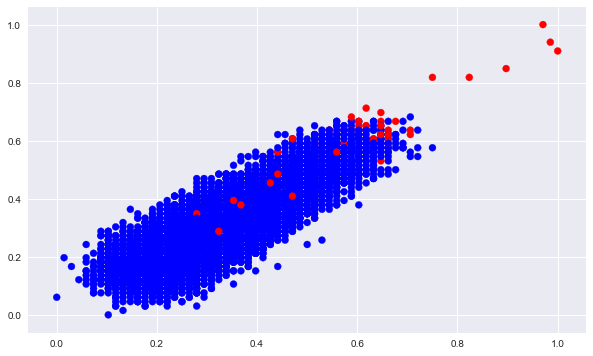

In [109]:
colors = ListedColormap(['red', 'blue'])
plt.figure(figsize = (10, 6))
plt.scatter(data_sample_sc[:,3], data_sample_sc[:,13], c = y_if_pred, cmap = colors)
plt.legend(loc='best')
plt.show()

In [110]:
res =clf_if.decision_function(data_sample_sc)

In [111]:
print(min(res), max(res))

-0.162502394768 0.136615883531


### 7.4. Модель на основе метода ближайших соседей  (Local Outlier Factor)

In [112]:
clf_lof = LocalOutlierFactor(n_neighbors=50, contamination=0.01)
y_lof_pred = clf_lof.fit_predict(data_sample_sc)

In [113]:
(y_lof_pred == -1).sum()

162

### 7.4.2. Визуализация аутлайеров
Визуализируем аутлайеров (красные точки) среди нормальных объектов (синие точки) обучающей выборке в двух измерениях

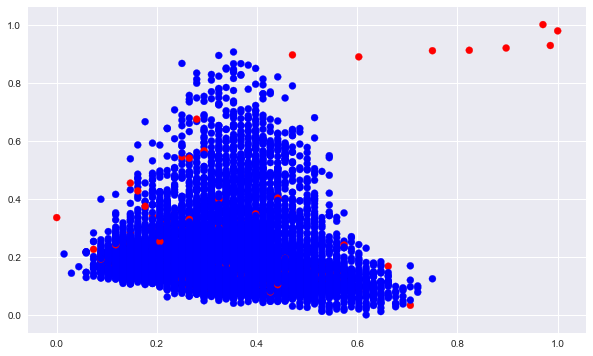

In [114]:
colors = ListedColormap(['red', 'blue'])
plt.figure(figsize = (10, 6))
plt.scatter(data_sample_sc[:,3], data_sample_sc[:,14], c = y_lof_pred, cmap = colors)
plt.legend(loc='best')
plt.show()

### 7.4.3. Результаты
Список объектов "Моторы и циклы", которые модель разметила как аномальные

In [115]:
a = list(y_lof_pred)
indices = [i for i, x in enumerate(a) if x == -1]
lof_res_train = data1.ix[indices]
lof_res_train

id  cycle      s1  s10    s11     s12      s13      s14     s15  \
234    Engine_10     43  518.67  1.3  47.10  522.41  2388.00  8140.62  8.3808   
346    Engine_10    155  518.67  1.3  47.54  521.11  2388.05  8150.01  8.3938   
356    Engine_10    165  518.67  1.3  47.75  521.27  2388.07  8149.96  8.4232   
373    Engine_10    182  518.67  1.3  47.60  521.46  2388.09  8154.96  8.4713   
399    Engine_10    208  518.67  1.3  47.98  520.09  2388.20  8171.64  8.4850   
438    Engine_11     25  518.67  1.3  47.30  522.64  2387.99  8137.69  8.3910   
463    Engine_11     50  518.67  1.3  47.20  521.92  2388.04  8143.91  8.4526   
828    Engine_13      5  518.67  1.3  47.56  521.32  2388.14  8133.30  8.3731   
1077   Engine_14     91  518.67  1.3  47.60  521.49  2388.12  8141.55  8.4608   
1138   Engine_14    152  518.67  1.3  47.88  520.07  2388.13  8166.11  8.4977   
1204   Engine_15     38  518.67  1.3  47.09  522.98  2388.03  8145.89  8.3884   
1225   Engine_15     59  518.67  1.3  47.43  522.59  2388.04  8146.59  8.3715   
1380   Engine_16      7  518.67  1.3  47.58  521.25  2388.04  8139.30  8.3989   
1390   Engine_16     17  518.67  1.3  47.68  521.64  2388.06  8137.54  8.5058   
1605   Engine_17     23  518.67  1.3  47.13  522.87  2387.99  8147.02  8.4123   
1765   Engine_17    183  518.67  1.3  47.37  521.77  2388.05  8158.22  8.4170   
1788   Engine_17    206  518.67  1.3  47.59  522.13  2388.04  8168.01  8.4346   
1831   Engine_17    249  518.67  1.3  47.96  521.15  2388.14  8205.17  8.4987   
1862   Engine_18      4  518.67  1.3  47.29  521.63  2388.00  8139.74  8.3789   
2030   Engine_18    172  518.67  1.3  47.82  521.35  2388.05  8211.40  8.4363   
2053   Engine_18    195  518.67  1.3  48.01  519.44  2388.39  8282.50  8.5132   
2134   Engine_19     81  518.67  1.3  47.57  521.58  2388.18  8125.55  8.4484   
2246    Engine_2     35  518.67  1.3  47.25  522.00  2388.00  8142.08  8.4164   
2409    Engine_2    198  518.67  1.3  47.14  521.50  2388.05  8146.21  8.4410   
2473    Engine_2    262  518.67  1.3  47.82  520.68  2388.12  8157.10  8.4670   
2564   Engine_20     66  518.67  1.3  47.51  521.20  2388.05  8146.16  8.4593   
2793   Engine_21     61  518.67  1.3  47.53  522.43  2388.08  8133.14  8.4120   
2865   Engine_21    133  518.67  1.3  47.57  521.93  2388.04  8147.10  8.4356   
2971   Engine_22     44  518.67  1.3  47.51  521.05  2388.16  8125.62  8.5020   
2985   Engine_22     58  518.67  1.3  47.49  520.92  2388.14  8120.97  8.4607   
...          ...    ...     ...  ...    ...     ...      ...      ...     ...   
13490   Engine_7    108  518.67  1.3  47.34  522.64  2387.96  8147.96  8.3605   
13551   Engine_7    169  518.67  1.3  47.63  522.64  2388.02  8153.92  8.4133   
13636   Engine_7    254  518.67  1.3  47.98  519.48  2388.27  8141.83  8.5627   
13650  Engine_70      9  518.67  1.3  47.26  521.76  2388.08  8140.31  8.4612   
13785  Engine_71      7  518.67  1.3  47.37  521.30  2388.15  8123.34  8.4427   
13787  Engine_71      9  518.67  1.3  47.32  521.92  2388.08  8130.55  8.4580   
13810  Engine_71     32  518.67  1.3  47.58  521.50  2388.14  8120.29  8.4725   
13995  Engine_72      9  518.67  1.3  47.46  522.02  2388.06  8127.26  8.3678   
14053  Engine_72     67  518.67  1.3  47.33  522.00  2388.10  8126.98  8.4104   
14065  Engine_72     79  518.67  1.3  47.55  521.58  2388.05  8126.76  8.3830   
14590  Engine_75     12  518.67  1.3  47.28  521.51  2388.16  8127.79  8.4332   
14866  Engine_76     59  518.67  1.3  47.75  521.67  2388.10  8131.95  8.5063   
15052  Engine_77     35  518.67  1.3  47.45  521.05  2388.16  8128.89  8.3685   
15078  Engine_77     61  518.67  1.3  47.58  521.56  2388.11  8126.26  8.4144   
15175  Engine_78      4  518.67  1.3  47.04  522.10  2388.01  8140.27  8.3548   
15305  Engine_78    134  518.67  1.3  47.39  522.01  2388.03  8142.39  8.4452   
15616   Engine_8     15  518.67  1.3  47.62  521.48  2388.16  8126.20  8.4934   
15617   Engine_8     16  518.67  1.3  47.57  

In [116]:
res_svm_if_train = svm_res_train[svm_res_train.isin(iforest_res_train)].dropna()

In [117]:
res_fin_train = res_svm_if_train[res_svm_if_train.isin(lof_res_train)].dropna()

### 7.5. Результат объединения трех моделей: One-Class-SVM, Isolation Forest, Local Outlier Factor
Объединяем результаты трех baseline моделей машинного обучения для уменьшения числа ложных срабатываний. Результат может быть улучшен за счет более детального подбора признаков в обучающей выборке и подборе параметров для моделей. За счет настройки параметров можно также отловить моторы, которые относятся к "группе риска".
Список моторов, которые наиболее вероятно, выйдут из строя на следующем цикле, приведен ниже. Расширенный список моторов из "группы риска" смотреть в разделе 5. Как можно видеть, результат близок к тому, что мы получили, проверив простые статистические гипотезы относительно аномалий во временных рядах.

In [118]:
res_fin_train

id  cycle      s1  s10    s11     s12      s13      s14     s15  \
2053   Engine_18  195.0  518.67  1.3  48.01  519.44  2388.39  8282.50  8.5132   
6378   Engine_39  125.0  518.67  1.3  48.34  520.04  2388.27  8112.34  8.5306   
8427   Engine_48  230.0  518.67  1.3  48.12  520.76  2388.20  8276.20  8.5112   
8428   Engine_48  231.0  518.67  1.3  47.98  520.53  2388.55  8290.25  8.4923   
9321   Engine_51  211.0  518.67  1.3  48.27  520.24  2388.29  8279.86  8.5275   
9322   Engine_51  212.0  518.67  1.3  48.09  520.36  2388.49  8288.26  8.5117   
9323   Engine_51  213.0  518.67  1.3  47.89  520.20  2388.54  8293.72  8.5306   
11157   Engine_6  186.0  518.67  1.3  48.27  519.80  2388.36  8108.26  8.5013   
16136   Engine_9  200.0  518.67  1.3  47.98  520.35  2388.44  8279.79  8.4968   
16137   Engine_9  201.0  518.67  1.3  48.11  520.28  2388.56  8289.63  8.5156   

        s16    ...         s21       s3       s4     s5     s6      s7  \
2053   0.03    ...     23.0304  1601.00  1428.08  14.62  21.61  551.43   
6378   0.03    ...     23.2056  1600.98  1436.58  14.62  21.61  549.85   
8427   0.03    ...     23.0147  1600.58  1429.60  14.62  21.61  551.83   
8428   0.03    ...     23.0188  1609.54  1435.19  14.62  21.61  551.65   
9321   0.03    ...     23.0668  1609.75  1419.91  14.62  21.61  552.63   
9322   0.03    ...     23.0834  1602.44  1432.71  14.62  21.61  552.73   
9323   0.03    ...     23.0958  1606.60  1428.55  14.62  21.61  551.60   
11157  0.03    ...     22.9396  1603.59  1430.37  14.62  21.61  550.59   
16136  0.03    ...     23.1008  1602.89  1431.95  14.62  21.61  552.29   
16137  0.03    ...     23.0284  1595.36  1428.43  14.62  21.61  552.30   

            s8       s9  setting1  setting2  
2053   2388.44  9224.53   -0.0029   -0.0001  
6378   2388.32  9048.84    0.0062    0.0002  
8427   2388.19  9221.31    0.0038    0.0005  
8428   2388.52  9228.53   -0.0025   -0.0005  
9321   2388.32  9219.81    0.0008   -0.0005  
9322   2388.46  9226.60    0.0015    0.0005  
9323   2388.56  9244.59    0.0014    0.0004  
11157  2388.31  9029.07   -0.0054   -0.0001  
16136  2388.44  9224.87   -0.0014   -0.0004  
16137  2388.50  9239.76   -0.0016    0.0004  

[10 rows x 25 columns]

### 7.6. Проверка

In [119]:
statistic_anomaly_detection(data1, ["Engine_9"], 3, 1)

Engine with detected anomaly by sensors:  Engine_9


cycles            outliers  \
Engine_9 cycle              0                   0   
         s11                0                   0   
         s12                0                   0   
         s13       [200, 201]  [2388.44, 2388.56]   
         s14            [201]           [8289.63]   
         s15                0                   0   
         s17                0                   0   
         s2                 0                   0   
         s20                0                   0   
         s21                0                   0   
         s3                 0                   0   
         s4                 0                   0   
         s7                 0                   0   
         s8        [200, 201]   [2388.44, 2388.5]   
         s9         [24, 201]  [9051.59, 9239.76]   
         setting1           0                   0   
         setting2           0                   0   

                                prediction_errors  
Engine_9 cycle                                  0  
         s11                                    0  
         s12                                    0  
         s13       [847.336255751, 1222.21350351]  
         s14                      [419.319192795]  
         s15                                    0  
         s17                                    0  
         s2                                     0  
         s20                                    0  
         s21                                    0  
         s3                                     0  
         s4                                     0  
         s7                                     0  
         s8        [868.152277833, 1049.19430512]  
         s9        [416.819509849, 465.099395871]  
         setting1                               0  
         setting2                               0

Bias constant: 2387.9886883848812, Sign constant: 9.261322583133796e-18, Power law constant: 7.094936613928798
Standard deviation: 0.04671245925251302, Percentile p = 95% : 2388.1


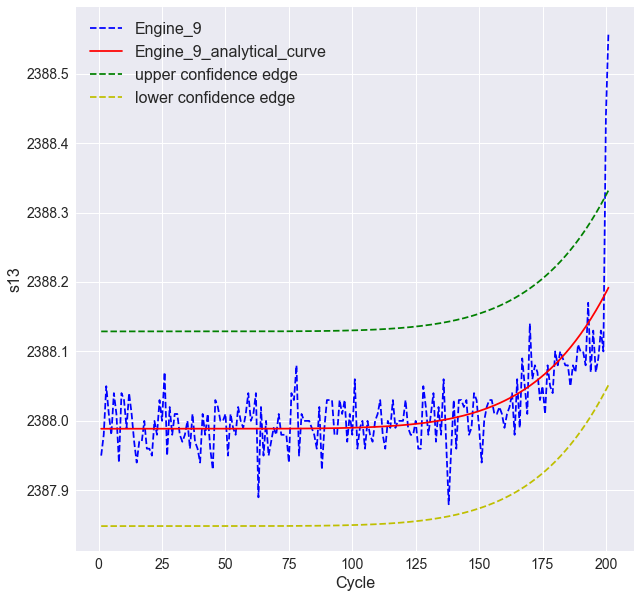

In [120]:
visualize_features("Engine_9","s13")

### 8. Анализ тестовой выборки
Проделаем вышеописанные процедуры для обнаружения аномалий / наиболее вероятных поломок среди моторов тестовой выборки.

### 8.1. Строим функции плотности вероятности (и гистограммы) для признаков и смотрим на распределения
Синим показаны функции плотности вероятности для каждого признака (измерения с датчика) по всем моторам в датасете в датасете и зеленым - только для мотора Engine_9

Заметим, что большинство функций имеет форму нормального распределения.
Видим, что некоторые признаки просто не вариативны, являются констанстами на всей обучающей выборке. Они не несут для нас никакой полезной информации

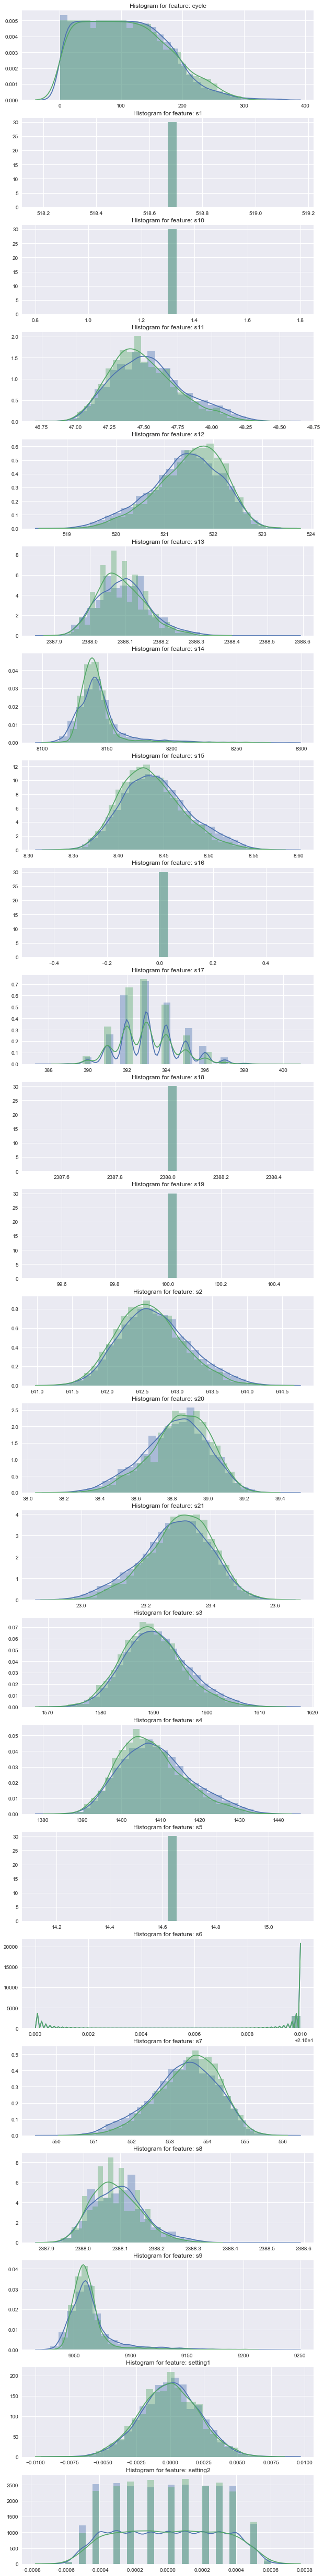

In [121]:
data = datat
plot_features = num_cols
plt.figure(figsize=(10,90))
grids = gridspec.GridSpec(len(plot_features),1)
for i,j in enumerate(data[plot_features]):
    ax = plt.subplot(grids[i])
    sns.distplot(data[j][data.label == 0], bins=30)
    sns.distplot(data[j][data.label == 1], bins=30)
    ax.set_xlabel('')
    #ax.set_xlim(-2,2)
    ax.set_title('Histogram for feature: ' + str(j))
plt.show()

Аномалии в тестовой выборке гораздо менее выражены, чем в обучающей

Идентифицируем аутлайеров на последних циклах измерений датчиков (последние 5% измерений), если они там возникают, то это наиболее вероятно приведет к поломке на следующем цикле

In [122]:
statistic_anomaly_detection(data2, eng_id2, 3, 1)

Engine with detected anomaly by sensors:  Engine_81
Engine with detected anomaly by sensors:  Engine_88
Engine with detected anomaly by sensors:  Engine_94
Engine with detected anomaly by sensors:  Engine_97


cycles  outliers  prediction_errors
Engine_99 cycle          0         0                  0
          s11            0         0                  0
          s12            0         0                  0
          s13            0         0                  0
          s14            0         0                  0
          s15            0         0                  0
          s17            0         0                  0
          s2             0         0                  0
          s20            0         0                  0
          s21            0         0                  0
          s3             0         0                  0
          s4             0         0                  0
          s7             0         0                  0
          s8             0         0                  0
          s9             0         0                  0
          setting1       0         0                  0
          setting2       0         0                  0

In [123]:
statistic_anomaly_detection(data2, ["Engine_81"], 3, 1)

Engine with detected anomaly by sensors:  Engine_81


cycles   outliers prediction_errors
Engine_81 cycle         0          0                 0
          s11           0          0                 0
          s12           0          0                 0
          s13           0          0                 0
          s14           0          0                 0
          s15           0          0                 0
          s17           0          0                 0
          s2            0          0                 0
          s20           0          0                 0
          s21           0          0                 0
          s3            0          0                 0
          s4            0          0                 0
          s7            0          0                 0
          s8            0          0                 0
          s9        [231]  [9046.41]   [393.402675733]
          setting1      0          0                 0
          setting2      0          0                 0

Bias constant: 9059.759521360062, Sign constant: 1.195850372071002, Power law constant: -2.3629577359573295
Standard deviation: 4.269510735799692, Percentile p = 95% : 9066.829


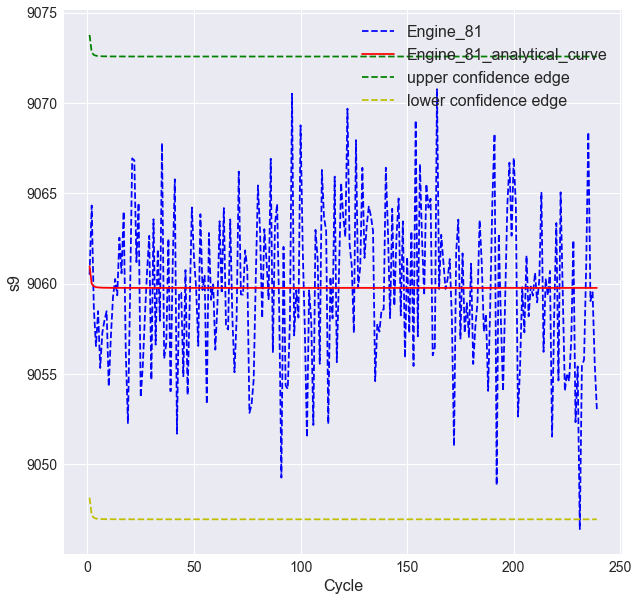

In [124]:
visualize_features("Engine_81","s9")

In [329]:
data = data_stat.copy()
for e in eng_id2:
    for c in li:
        v = data[(data.id == e) & (data.flag == 1.0)][c].values[0]
        i = data[(data.id == e) & (data.flag == 1.0)][c].index
        minv = data[(data.id != e) & (data.flag == 0.0)][c].min()
        maxv = data[(data.id != e) & (data.flag == 0.0)][c].max()
        if ((v < minv ) | (v > maxv)): 
            data.set_value(i,c,True)
        else:
            data.set_value(i,c,False)

In [330]:
res1 = pd.concat([data[data.flag == 1.0][li].sum(axis=1),data[data.flag == 1.0]["id"]], axis=1)

In [331]:
res1.columns = ['sum_abn','id']

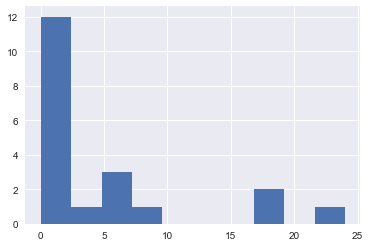

In [332]:
# Гистограмма числа аномалий в признаках по моторам
res1.sum_abn.hist()

In [333]:
res1['pseudo_proba'] = res1['sum_abn'] - res1['sum_abn'].mean()
res1['pseudo_proba'] = round((res1['pseudo_proba'] - res1['pseudo_proba'].min()) / (res1['pseudo_proba'].max() -
                                                                         res1['pseudo_proba'].min()),2)

In [334]:
res1[res1['pseudo_proba'] > res1['pseudo_proba'].mean()].sort_values(by=['pseudo_proba'], ascending=False)

sum_abn         id  pseudo_proba
92     24.0  Engine_92          1.00
91     18.0  Engine_91          0.75
95     18.0  Engine_95          0.75
83      9.0  Engine_83          0.38
97      6.0  Engine_97          0.25
99      6.0  Engine_99          0.25

### 8.1. Масштабируем обучающую выборку
Используем масштабирование на отрезок [0,1] для выравнивания масштабы признаков

In [311]:
data_sample_test = data2[num_cols_filtered]
data_sample_test_sc = scaler_minmax.transform(data_sample_test)

### 8.2. Одноклассовый SVM
На графике взаимосвязи признаков видно, что в двумерном подпространстве объекты образуют сферические/элипсоидальные скопления.
Поэтому логично применить Гауссову функцию в качестве ядра для метода опорных векторов.
Остальные параметры модели подбираются экспериментальным способом на основе анализа результатов

In [312]:
y_svm_pred_test = clf_svm.predict(data_sample_test_sc)

In [313]:
(y_svm_pred_test == -1).sum()

27

### 8.2.1. Визуализация аутлайеров
Визуализируем аутлайеров (красные точки) среди нормальных объектов (синие точки) обучающей выборке в двух измерениях

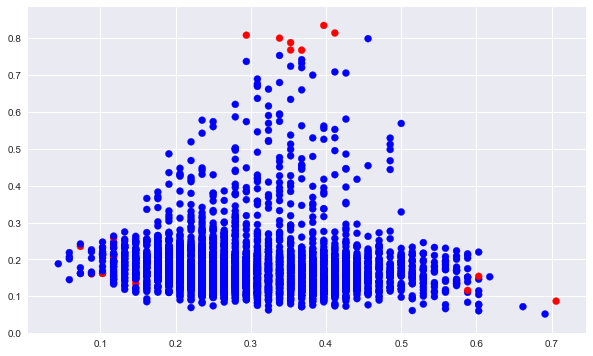

In [314]:
colors = ListedColormap(['red', 'blue'])
plt.figure(figsize = (10, 6))
plt.scatter(data_sample_test_sc[:,3], data_sample_test_sc[:,14], c = y_svm_pred_test, cmap = colors)
plt.legend(loc='best')
plt.show()

### 8.2.2. Результаты
Список объектов "Моторы и циклы", которые модель разметила как аномальные

In [315]:
a = list(y_svm_pred_test)
indices = [i for i, x in enumerate(a) if x == -1]
svm_res_test = data2.ix[indices]
svm_res_test

id  cycle      s1  s10    s11     s12      s13      s14     s15  \
437   Engine_81    239  518.67  1.3  48.43  519.09  2388.27  8127.27  8.5395   
447   Engine_82     10  518.67  1.3  47.10  522.84  2387.94  8146.73  8.4018   
454   Engine_82     17  518.67  1.3  47.21  522.73  2387.98  8144.86  8.3977   
647   Engine_82    210  518.67  1.3  48.17  520.66  2388.13  8246.16  8.5255   
648   Engine_82    211  518.67  1.3  48.04  520.73  2388.12  8258.32  8.5230   
650   Engine_82    213  518.67  1.3  48.18  520.43  2388.11  8262.35  8.5441   
652   Engine_83      2  518.67  1.3  47.07  522.67  2387.98  8142.31  8.3902   
657   Engine_83      7  518.67  1.3  47.16  522.99  2388.00  8138.93  8.3746   
661   Engine_83     11  518.67  1.3  47.21  522.97  2387.95  8141.79  8.4285   
668   Engine_83     18  518.67  1.3  47.04  522.14  2388.02  8143.73  8.3917   
670   Engine_83     20  518.67  1.3  47.06  522.40  2387.98  8139.69  8.3693   
679   Engine_83     29  518.67  1.3  47.23  522.19  2388.00  8144.59  8.3759   
700   Engine_83     50  518.67  1.3  47.16  522.59  2387.98  8141.17  8.3635   
702   Engine_83     52  518.67  1.3  47.04  522.34  2388.01  8135.22  8.3950   
1357  Engine_85    187  518.67  1.3  48.35  518.83  2388.29  8127.76  8.5517   
1792  Engine_87    177  518.67  1.3  48.34  519.78  2388.28  8125.16  8.5164   
2345  Engine_90    153  518.67  1.3  48.26  519.73  2388.36  8113.53  8.5490   
3033  Engine_95      1  518.67  1.3  47.20  522.74  2387.93  8153.89  8.3884   
3042  Engine_95     10  518.67  1.3  47.05  522.32  2387.96  8150.62  8.3772   
3043  Engine_95     11  518.67  1.3  47.13  522.61  2387.98  8154.61  8.3855   
3046  Engine_95     14  518.67  1.3  47.05  523.01  2387.96  8151.47  8.3516   
3050  Engine_95     18  518.67  1.3  47.08  522.89  2387.96  8147.51  8.4382   
3071  Engine_95     39  518.67  1.3  47.04  522.68  2387.96  8151.08  8.3849   
3727  Engine_97    198  518.67  1.3  48.16  520.41  2388.12  8255.95  8.5132   
3728  Engine_97    199  518.67  1.3  48.07  520.13  2388.08  8258.58  8.4981   
3729  Engine_97    200  518.67  1.3  48.04  519.98  2388.16  8257.38  8.5402   
3730  Engine_97    201  518.67  1.3  48.18  520.06  2388.15  8270.91  8.5514   

       s16    ...         s21       s3       s4     s5     s6      s7  \
437   0.03    ...     23.0611  1602.45  1429.38  14.62  21.61  550.82   
447   0.03    ...     23.6184  1580.98  1395.96  14.62  21.60  554.80   
454   0.03    ...     23.4522  1571.06  1397.03  14.62  21.61  554.75   
647   0.03    ...     23.0639  1608.87  1434.28  14.62  21.61  551.51   
648   0.03    ...     23.0294  1605.00  1426.94  14.62  21.61  552.46   
650   0.03    ...     23.0412  1596.98  1425.66  14.62  21.61  552.05   
652   0.03    ...     23.3193  1575.29  1393.01  14.62  21.61  555.09   
657   0.03    ...     23.5112  1583.91  1396.79  14.62  21.61  554.36   
661   0.03    ...     23.3848  1577.50  1390.48  14.62  21.61  554.90   
668   0.03    ...     23.3965  1579.52  1392.34  14.62  21.61  554.82   
670   0.03    ...     23.3995  1576.76  1393.19  14.62  21.61  554.74   
679   0.03    ...     23.4044  1583.51  1391.57  14.62  21.61  554.38   
700   0.03    ...     23.5316  1574.96  1385.75  14.62  21.61  555.05   
702   0.03    ...     23.4812  1580.01  1392.51  14.62  21.61  554.95   
1357  0.03    ...     23.1251  1597.34  1430.78  14.62  21.61  551.02   
1792  0.03    ...     23.0864  1600.61  1432.55  14.62  21.61  551.18   
2345  0.03    ...     22.9678  1609.33  1429.50  14.62  21.61  551.24   
3033  0.03    ...     23.4483  1581.56  1387.38  14.62  21.60  555.01   
3042  0.03    ...     23.4350  1580.85  1392.92  14.62  21.61  554.64   
3043  0.03    ...     23.4258  1580.17  1391.90  14.62  21.61  554.23   
3046  0.03    ...     23.4343  1582.89  1393.80  14.62  21.61  554.90   
3050  0.03    ...     23.4898  1577.97  1399.90  14.62  21.61  555.15   
3071  0.03    ...     23.5627  1581.66  1397.86  14.62  21.60  554.10   
3727  0.03    ...   

### 8.3. Модель на основе решающих деревьев  (Isolation Forest)

In [316]:
y_if_pred_test = clf_if.predict(data_sample_test_sc)

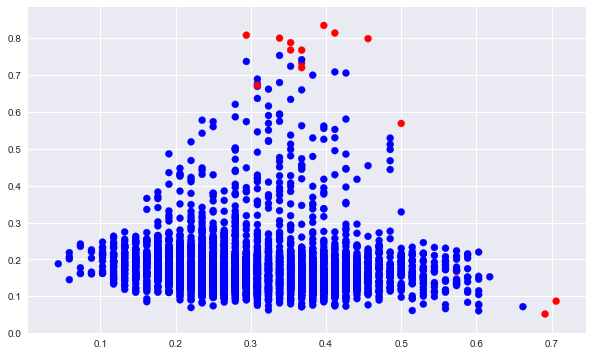

In [317]:
colors = ListedColormap(['red', 'blue'])
plt.figure(figsize = (10, 6))
plt.scatter(data_sample_test_sc[:,3], data_sample_test_sc[:,14], c = y_if_pred_test, cmap = colors)
plt.legend(loc='best')
plt.show()

### 8.3.2. Результаты
Список объектов "Моторы и циклы", которые модель разметила как аномальные

In [318]:
a = list(y_if_pred_test)
indices = [i for i, x in enumerate(a) if x == -1]
iforest_res_test = data2.ix[indices]
iforest_res_test

id  cycle      s1  s10    s11     s12      s13      s14     s15  \
435   Engine_81    237  518.67  1.3  48.16  519.20  2388.27  8130.88  8.5197   
437   Engine_81    239  518.67  1.3  48.43  519.09  2388.27  8127.27  8.5395   
645   Engine_82    208  518.67  1.3  48.08  520.81  2388.13  8246.23  8.5340   
646   Engine_82    209  518.67  1.3  48.17  521.06  2388.13  8246.71  8.5333   
647   Engine_82    210  518.67  1.3  48.17  520.66  2388.13  8246.16  8.5255   
648   Engine_82    211  518.67  1.3  48.04  520.73  2388.12  8258.32  8.5230   
649   Engine_82    212  518.67  1.3  48.22  520.16  2388.19  8255.68  8.5338   
650   Engine_82    213  518.67  1.3  48.18  520.43  2388.11  8262.35  8.5441   
2344  Engine_90    152  518.67  1.3  48.09  519.35  2388.35  8113.55  8.5124   
2345  Engine_90    153  518.67  1.3  48.26  519.73  2388.36  8113.53  8.5490   
3032  Engine_94    257  518.67  1.3  48.32  520.02  2388.22  8216.89  8.4959   
3721  Engine_97    192  518.67  1.3  47.97  521.33  2388.09  8228.95  8.5013   
3727  Engine_97    198  518.67  1.3  48.16  520.41  2388.12  8255.95  8.5132   
3728  Engine_97    199  518.67  1.3  48.07  520.13  2388.08  8258.58  8.4981   
3729  Engine_97    200  518.67  1.3  48.04  519.98  2388.16  8257.38  8.5402   
3730  Engine_97    201  518.67  1.3  48.18  520.06  2388.15  8270.91  8.5514   

       s16    ...         s21       s3       s4     s5     s6      s7  \
435   0.03    ...     23.0948  1608.12  1432.04  14.62  21.61  551.11   
437   0.03    ...     23.0611  1602.45  1429.38  14.62  21.61  550.82   
645   0.03    ...     23.1126  1607.74  1426.26  14.62  21.61  552.35   
646   0.03    ...     23.0434  1604.53  1426.18  14.62  21.61  551.90   
647   0.03    ...     23.0639  1608.87  1434.28  14.62  21.61  551.51   
648   0.03    ...     23.0294  1605.00  1426.94  14.62  21.61  552.46   
649   0.03    ...     23.2379  1601.47  1426.74  14.62  21.61  551.85   
650   0.03    ...     23.0412  1596.98  1425.66  14.62  21.61  552.05   
2344  0.03    ...     23.0969  1602.68  1422.35  14.62  21.61  551.75   
2345  0.03    ...     22.9678  1609.33  1429.50  14.62  21.61  551.24   
3032  0.03    ...     23.1518  1604.05  1431.12  14.62  21.61  551.32   
3721  0.03    ...     23.0860  1610.06  1421.38  14.62  21.61  552.03   
3727  0.03    ...     22.9548  1605.46  1426.47  14.62  21.61  553.18   
3728  0.03    ...     23.0657  1605.94  1429.90  14.62  21.61  551.84   
3729  0.03    ...     23.0501  1601.34  1429.40  14.62  21.61  552.04   
3730  0.03    ...     23.1451  1606.90  1430.66  14.62  21.61  552.19   

           s8       s9  setting1  setting2  
435   2388.30  9059.52   -0.0004    0.0000  
437   2388.22  9053.05    0.0068    0.0005  
645   2388.12  9182.21   -0.0021    0.0000  
646   2388.19  9184.89    0.0006    0.0002  
647   2388.13  9192.80    0.0002   -0.0005  
648   2388.16  9192.88   -0.0004   -0.0004  
649   2388.13  9199.74    0.0004    0.0004  
650   2388.12  9200.05   -0.0036    0.0001  
2344  2388.32  9033.32   -0.0005    0.0000  
2345  2388.30  9041.11    0.0023    0.0002  
3032  2388.22  9148.49   -0.0036   -0.0002  
3721  2388.11  9171.51    0.0021   -0.0001  
3727  2388.15  9197.35   -0.0008   -0.0002  
3728  2388.16  9201.83    0.0019   -0.0002  
3729  2388.12  9203.16   -0.0035    0.0005  
3730  2388.19  9207.74   -0.0026   -0.0001  

[16 rows x 25 columns]

### 8.4. Модель на основе метода ближайших соседей  (Local Outlier Factor)

In [319]:
clf_lof2 = LocalOutlierFactor(n_neighbors=500, contamination=0.01)
y_lof_pred_test = clf_lof2.fit_predict(data_sample_test_sc)

In [320]:
(y_lof_pred_test == -1).sum()

41

### 8.4.2. Визуализация аутлайеров
Визуализируем аутлайеров (красные точки) среди нормальных объектов (синие точки) обучающей выборке в двух измерениях

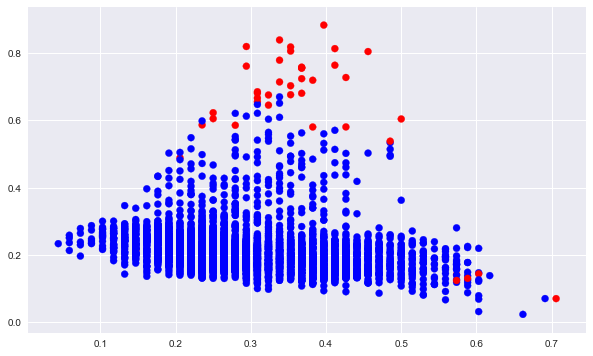

In [321]:
colors = ListedColormap(['red', 'blue'])
plt.figure(figsize = (10, 6))
plt.scatter(data_sample_test_sc[:,3], data_sample_test_sc[:,4], c = y_lof_pred_test, cmap = colors)
plt.legend(loc='best')
plt.show()

### 8.4.3. Результаты
Список объектов "Моторы и циклы", которые модель разметила как аномальные

In [322]:
a = list(y_lof_pred_test)
indices = [i for i, x in enumerate(a) if x == -1]
lof_res_test = data2.ix[indices]
lof_res_test

id  cycle      s1  s10    s11     s12      s13      s14     s15  \
437   Engine_81    239  518.67  1.3  48.43  519.09  2388.27  8127.27  8.5395   
619   Engine_82    182  518.67  1.3  47.73  521.96  2388.02  8194.56  8.4508   
629   Engine_82    192  518.67  1.3  47.59  521.50  2388.05  8217.06  8.4807   
635   Engine_82    198  518.67  1.3  47.69  520.89  2388.05  8220.49  8.4990   
636   Engine_82    199  518.67  1.3  47.69  520.79  2388.10  8224.85  8.4997   
637   Engine_82    200  518.67  1.3  47.69  520.92  2388.12  8230.84  8.4930   
638   Engine_82    201  518.67  1.3  47.97  520.97  2388.09  8226.85  8.4940   
639   Engine_82    202  518.67  1.3  47.97  520.51  2388.13  8231.67  8.4862   
640   Engine_82    203  518.67  1.3  47.90  520.56  2388.09  8231.75  8.4952   
641   Engine_82    204  518.67  1.3  47.88  520.84  2388.10  8230.69  8.5178   
642   Engine_82    205  518.67  1.3  47.88  520.63  2388.14  8239.17  8.4865   
643   Engine_82    206  518.67  1.3  47.92  520.03  2388.12  8236.00  8.4865   
644   Engine_82    207  518.67  1.3  47.94  520.83  2388.08  8247.28  8.5087   
645   Engine_82    208  518.67  1.3  48.08  520.81  2388.13  8246.23  8.5340   
646   Engine_82    209  518.67  1.3  48.17  521.06  2388.13  8246.71  8.5333   
647   Engine_82    210  518.67  1.3  48.17  520.66  2388.13  8246.16  8.5255   
648   Engine_82    211  518.67  1.3  48.04  520.73  2388.12  8258.32  8.5230   
649   Engine_82    212  518.67  1.3  48.22  520.16  2388.19  8255.68  8.5338   
650   Engine_82    213  518.67  1.3  48.18  520.43  2388.11  8262.35  8.5441   
700   Engine_83     50  518.67  1.3  47.16  522.59  2387.98  8141.17  8.3635   
1357  Engine_85    187  518.67  1.3  48.35  518.83  2388.29  8127.76  8.5517   
1789  Engine_87    174  518.67  1.3  48.04  519.93  2388.27  8123.96  8.5638   
1792  Engine_87    177  518.67  1.3  48.34  519.78  2388.28  8125.16  8.5164   
2345  Engine_90    153  518.67  1.3  48.26  519.73  2388.36  8113.53  8.5490   
3026  Engine_94    251  518.67  1.3  48.00  519.85  2388.21  8204.13  8.5240   
3028  Engine_94    253  518.67  1.3  48.16  520.01  2388.14  8212.27  8.5423   
3031  Engine_94    256  518.67  1.3  48.07  519.57  2388.17  8212.30  8.5452   
3032  Engine_94    257  518.67  1.3  48.32  520.02  2388.22  8216.89  8.4959   
3712  Engine_97    183  518.67  1.3  47.68  521.01  2388.04  8213.45  8.4877   
3713  Engine_97    184  518.67  1.3  47.86  521.04  2388.07  8213.26  8.4611   
3720  Engine_97    191  518.67  1.3  47.86  520.97  2388.09  8232.57  8.5344   
3721  Engine_97    192  518.67  1.3  47.97  521.33  2388.09  8228.95  8.5013   
3722  Engine_97    193  518.67  1.3  47.75  520.29  2388.11  8238.18  8.4864   
3723  Engine_97    194  518.67  1.3  47.85  520.78  2388.17  8240.75  8.4759   
3724  Engine_97    195  518.67  1.3  47.82  520.35  2388.16  8247.82  8.5138   
3725  Engine_97    196  518.67  1.3  47.87  520.83  2388.13  8240.08  8.4874   
3726  Engine_97    197  518.67  1.3  47.97  520.26  2388.11  8250.71  8.5596   
3727  Engine_97    198  518.67  1.3  48.16  520.41  2388.12  8255.95  8.5132   
3728  Engine_97    199  518.67  1.3  48.07  520.13  2388.08  8258.58  8.4981   
3729  Engine_97    200  518.67  1.3  48.04  519.98  2388.16  8257.38  8.5402   
3730  Engine_97    201  518.67  1.3  48.18  520.06  2388.15  8270.91  8.5514   

       s16    ...         s21       s3       s4     s5     s6      s7  \
437   0.03    ...     23.0611  1602.45  1429.38  14.62  21.61  550.82   
619   0.03    ...     23.1857  1597.04  1409.69  14.62  21.61  553.48   
629   0.03    ...     23.2327  1602.68  1410.50  14.62  21.61  553.00   
635   0.03    ...     23.1438  1602.87  1422.64  14.62  21.61  553.12   
636   0.03    ...     23.0799  1598.93  1424.94  14.62  21.61  552.56   
637   0.03    ...     23.1791  1602.40  1425.75  14.62  21.61  552.38   
638   0.03    ...     23.1539  1599.54  1427.61  14.62  21.61  551.93   
639   0.03    ...     23.1049  1591.99  1427.79  14.62  21.61  552.7

### 8.5. Результат объединения трех моделей: One-Class-SVM, Isolation Forest, Local Outlier Factor
Объединяем результаты трех baseline моделей машинного обучения для уменьшения числа ложных срабатываний. Результат может быть улучшен за счет более детального подбора признаков в обучающей выборке и подборе параметров для моделей. За счет настройки параметров можно также отловить моторы, которые относятся к "группе риска".
Можно отметить, что в тестовой выборке нет таких выраженных аномальных циклов, которые присутствовали в обучающей выборке.
Список моторов с проблемами на последних циклах, которые наиболее вероятно, выйдут из строя на следующем цикле, приведен ниже. Расширенный список моторов из "группы риска". 

In [323]:
res_svm_if_test = svm_res_test[svm_res_test.isin(iforest_res_test)].dropna()

### 8.5.1. Пересечение результатов двух моделей

In [324]:
res_svm_if_test

id  cycle      s1  s10    s11     s12      s13      s14     s15  \
437   Engine_81  239.0  518.67  1.3  48.43  519.09  2388.27  8127.27  8.5395   
647   Engine_82  210.0  518.67  1.3  48.17  520.66  2388.13  8246.16  8.5255   
648   Engine_82  211.0  518.67  1.3  48.04  520.73  2388.12  8258.32  8.5230   
650   Engine_82  213.0  518.67  1.3  48.18  520.43  2388.11  8262.35  8.5441   
2345  Engine_90  153.0  518.67  1.3  48.26  519.73  2388.36  8113.53  8.5490   
3727  Engine_97  198.0  518.67  1.3  48.16  520.41  2388.12  8255.95  8.5132   
3728  Engine_97  199.0  518.67  1.3  48.07  520.13  2388.08  8258.58  8.4981   
3729  Engine_97  200.0  518.67  1.3  48.04  519.98  2388.16  8257.38  8.5402   
3730  Engine_97  201.0  518.67  1.3  48.18  520.06  2388.15  8270.91  8.5514   

       s16    ...         s21       s3       s4     s5     s6      s7  \
437   0.03    ...     23.0611  1602.45  1429.38  14.62  21.61  550.82   
647   0.03    ...     23.0639  1608.87  1434.28  14.62  21.61  551.51   
648   0.03    ...     23.0294  1605.00  1426.94  14.62  21.61  552.46   
650   0.03    ...     23.0412  1596.98  1425.66  14.62  21.61  552.05   
2345  0.03    ...     22.9678  1609.33  1429.50  14.62  21.61  551.24   
3727  0.03    ...     22.9548  1605.46  1426.47  14.62  21.61  553.18   
3728  0.03    ...     23.0657  1605.94  1429.90  14.62  21.61  551.84   
3729  0.03    ...     23.0501  1601.34  1429.40  14.62  21.61  552.04   
3730  0.03    ...     23.1451  1606.90  1430.66  14.62  21.61  552.19   

           s8       s9  setting1  setting2  
437   2388.22  9053.05    0.0068    0.0005  
647   2388.13  9192.80    0.0002   -0.0005  
648   2388.16  9192.88   -0.0004   -0.0004  
650   2388.12  9200.05   -0.0036    0.0001  
2345  2388.30  9041.11    0.0023    0.0002  
3727  2388.15  9197.35   -0.0008   -0.0002  
3728  2388.16  9201.83    0.0019   -0.0002  
3729  2388.12  9203.16   -0.0035    0.0005  
3730  2388.19  9207.74   -0.0026   -0.0001  

[9 rows x 25 columns]

In [325]:
res_fin_test = res_svm_if_test[res_svm_if_test.isin(lof_res_test)].dropna()

In [326]:
res_fin_test

id  cycle      s1  s10    s11     s12      s13      s14     s15  \
437   Engine_81  239.0  518.67  1.3  48.43  519.09  2388.27  8127.27  8.5395   
647   Engine_82  210.0  518.67  1.3  48.17  520.66  2388.13  8246.16  8.5255   
648   Engine_82  211.0  518.67  1.3  48.04  520.73  2388.12  8258.32  8.5230   
650   Engine_82  213.0  518.67  1.3  48.18  520.43  2388.11  8262.35  8.5441   
2345  Engine_90  153.0  518.67  1.3  48.26  519.73  2388.36  8113.53  8.5490   
3727  Engine_97  198.0  518.67  1.3  48.16  520.41  2388.12  8255.95  8.5132   
3728  Engine_97  199.0  518.67  1.3  48.07  520.13  2388.08  8258.58  8.4981   
3729  Engine_97  200.0  518.67  1.3  48.04  519.98  2388.16  8257.38  8.5402   
3730  Engine_97  201.0  518.67  1.3  48.18  520.06  2388.15  8270.91  8.5514   

       s16    ...         s21       s3       s4     s5     s6      s7  \
437   0.03    ...     23.0611  1602.45  1429.38  14.62  21.61  550.82   
647   0.03    ...     23.0639  1608.87  1434.28  14.62  21.61  551.51   
648   0.03    ...     23.0294  1605.00  1426.94  14.62  21.61  552.46   
650   0.03    ...     23.0412  1596.98  1425.66  14.62  21.61  552.05   
2345  0.03    ...     22.9678  1609.33  1429.50  14.62  21.61  551.24   
3727  0.03    ...     22.9548  1605.46  1426.47  14.62  21.61  553.18   
3728  0.03    ...     23.0657  1605.94  1429.90  14.62  21.61  551.84   
3729  0.03    ...     23.0501  1601.34  1429.40  14.62  21.61  552.04   
3730  0.03    ...     23.1451  1606.90  1430.66  14.62  21.61  552.19   

           s8       s9  setting1  setting2  
437   2388.22  9053.05    0.0068    0.0005  
647   2388.13  9192.80    0.0002   -0.0005  
648   2388.16  9192.88   -0.0004   -0.0004  
650   2388.12  9200.05   -0.0036    0.0001  
2345  2388.30  9041.11    0.0023    0.0002  
3727  2388.15  9197.35   -0.0008   -0.0002  
3728  2388.16  9201.83    0.0019   -0.0002  
3729  2388.12  9203.16   -0.0035    0.0005  
3730  2388.19  9207.74   -0.0026   -0.0001  

[9 rows x 25 columns]

### 8.6. Проверка

In [340]:
statistic_anomaly_detection(data2, ["Engine_97"], 3, 1)

Engine with detected anomaly by sensors:  Engine_97


cycles outliers prediction_errors
Engine_97 cycle         0        0                 0
          s11           0        0                 0
          s12           0        0                 0
          s13           0        0                 0
          s14           0        0                 0
          s15           0        0                 0
          s17       [199]    [400]   [473.325712007]
          s2            0        0                 0
          s20           0        0                 0
          s21           0        0                 0
          s3            0        0                 0
          s4            0        0                 0
          s7            0        0                 0
          s8            0        0                 0
          s9            0        0                 0
          setting1      0        0                 0
          setting2      0        0                 0

Bias constant: 391.9899460010166, Sign constant: 2.953547557458999e-12, Power law constant: 5.306053874888436
Standard deviation: 0.9176896102044565, Percentile p = 95% : 396.0


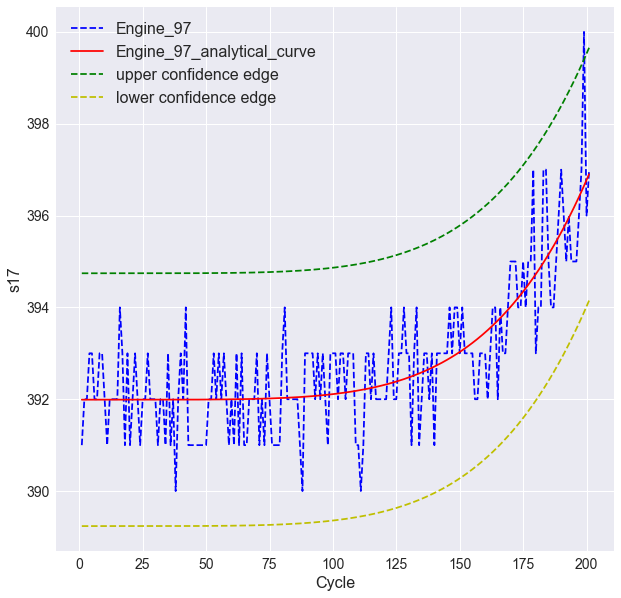

In [341]:
visualize_features("Engine_97","s17")

In [342]:
statistic_anomaly_detection(data2, ["Engine_81"], 3, 1)

Engine with detected anomaly by sensors:  Engine_81


cycles   outliers prediction_errors
Engine_81 cycle         0          0                 0
          s11           0          0                 0
          s12           0          0                 0
          s13           0          0                 0
          s14           0          0                 0
          s15           0          0                 0
          s17           0          0                 0
          s2            0          0                 0
          s20           0          0                 0
          s21           0          0                 0
          s3            0          0                 0
          s4            0          0                 0
          s7            0          0                 0
          s8            0          0                 0
          s9        [231]  [9046.41]   [393.402675733]
          setting1      0          0                 0
          setting2      0          0                 0